#In The Name Of God

##AI Project3

###Aidin Kazemi: 810101561


#Question 1

##Section A: Explaining About Pollicy Iteration

In [2]:
from google.colab import drive
drive.mount("/content/drive")

from IPython.display import Image

Mounted at /content/drive


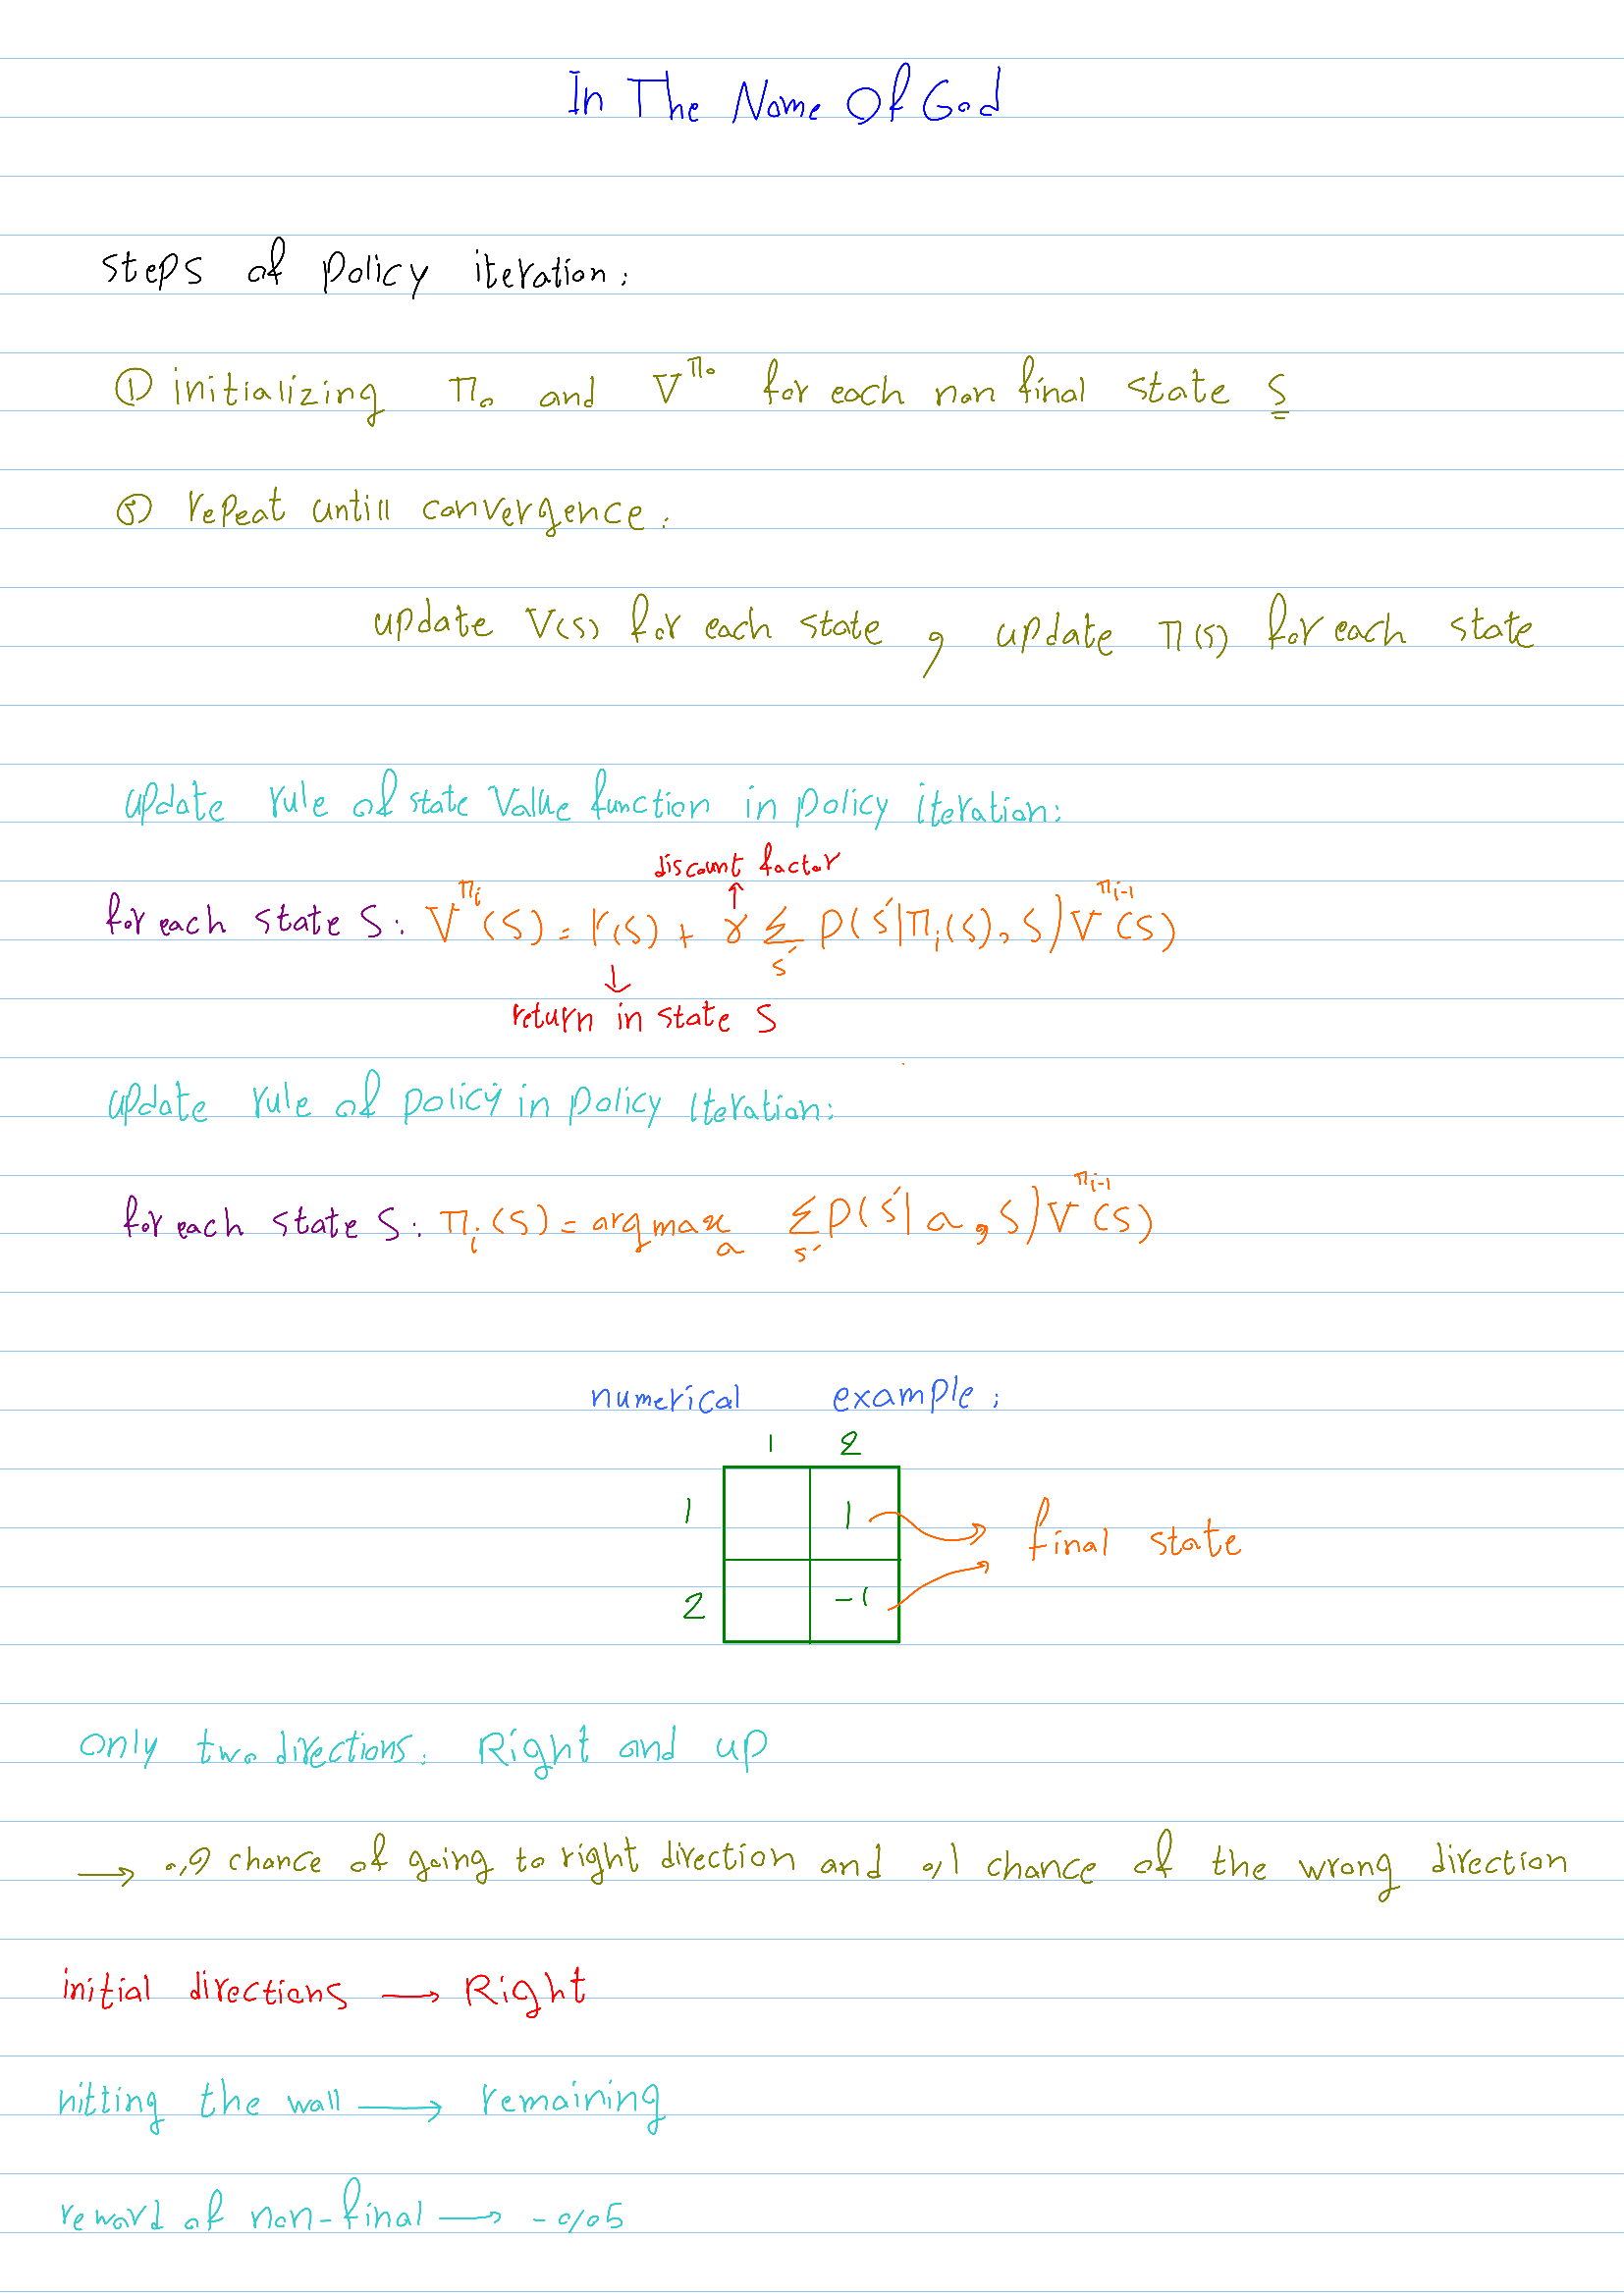

In [5]:
Image(filename = "/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q1/q1-part1_Page_1.png",width = 600,height = 1000)

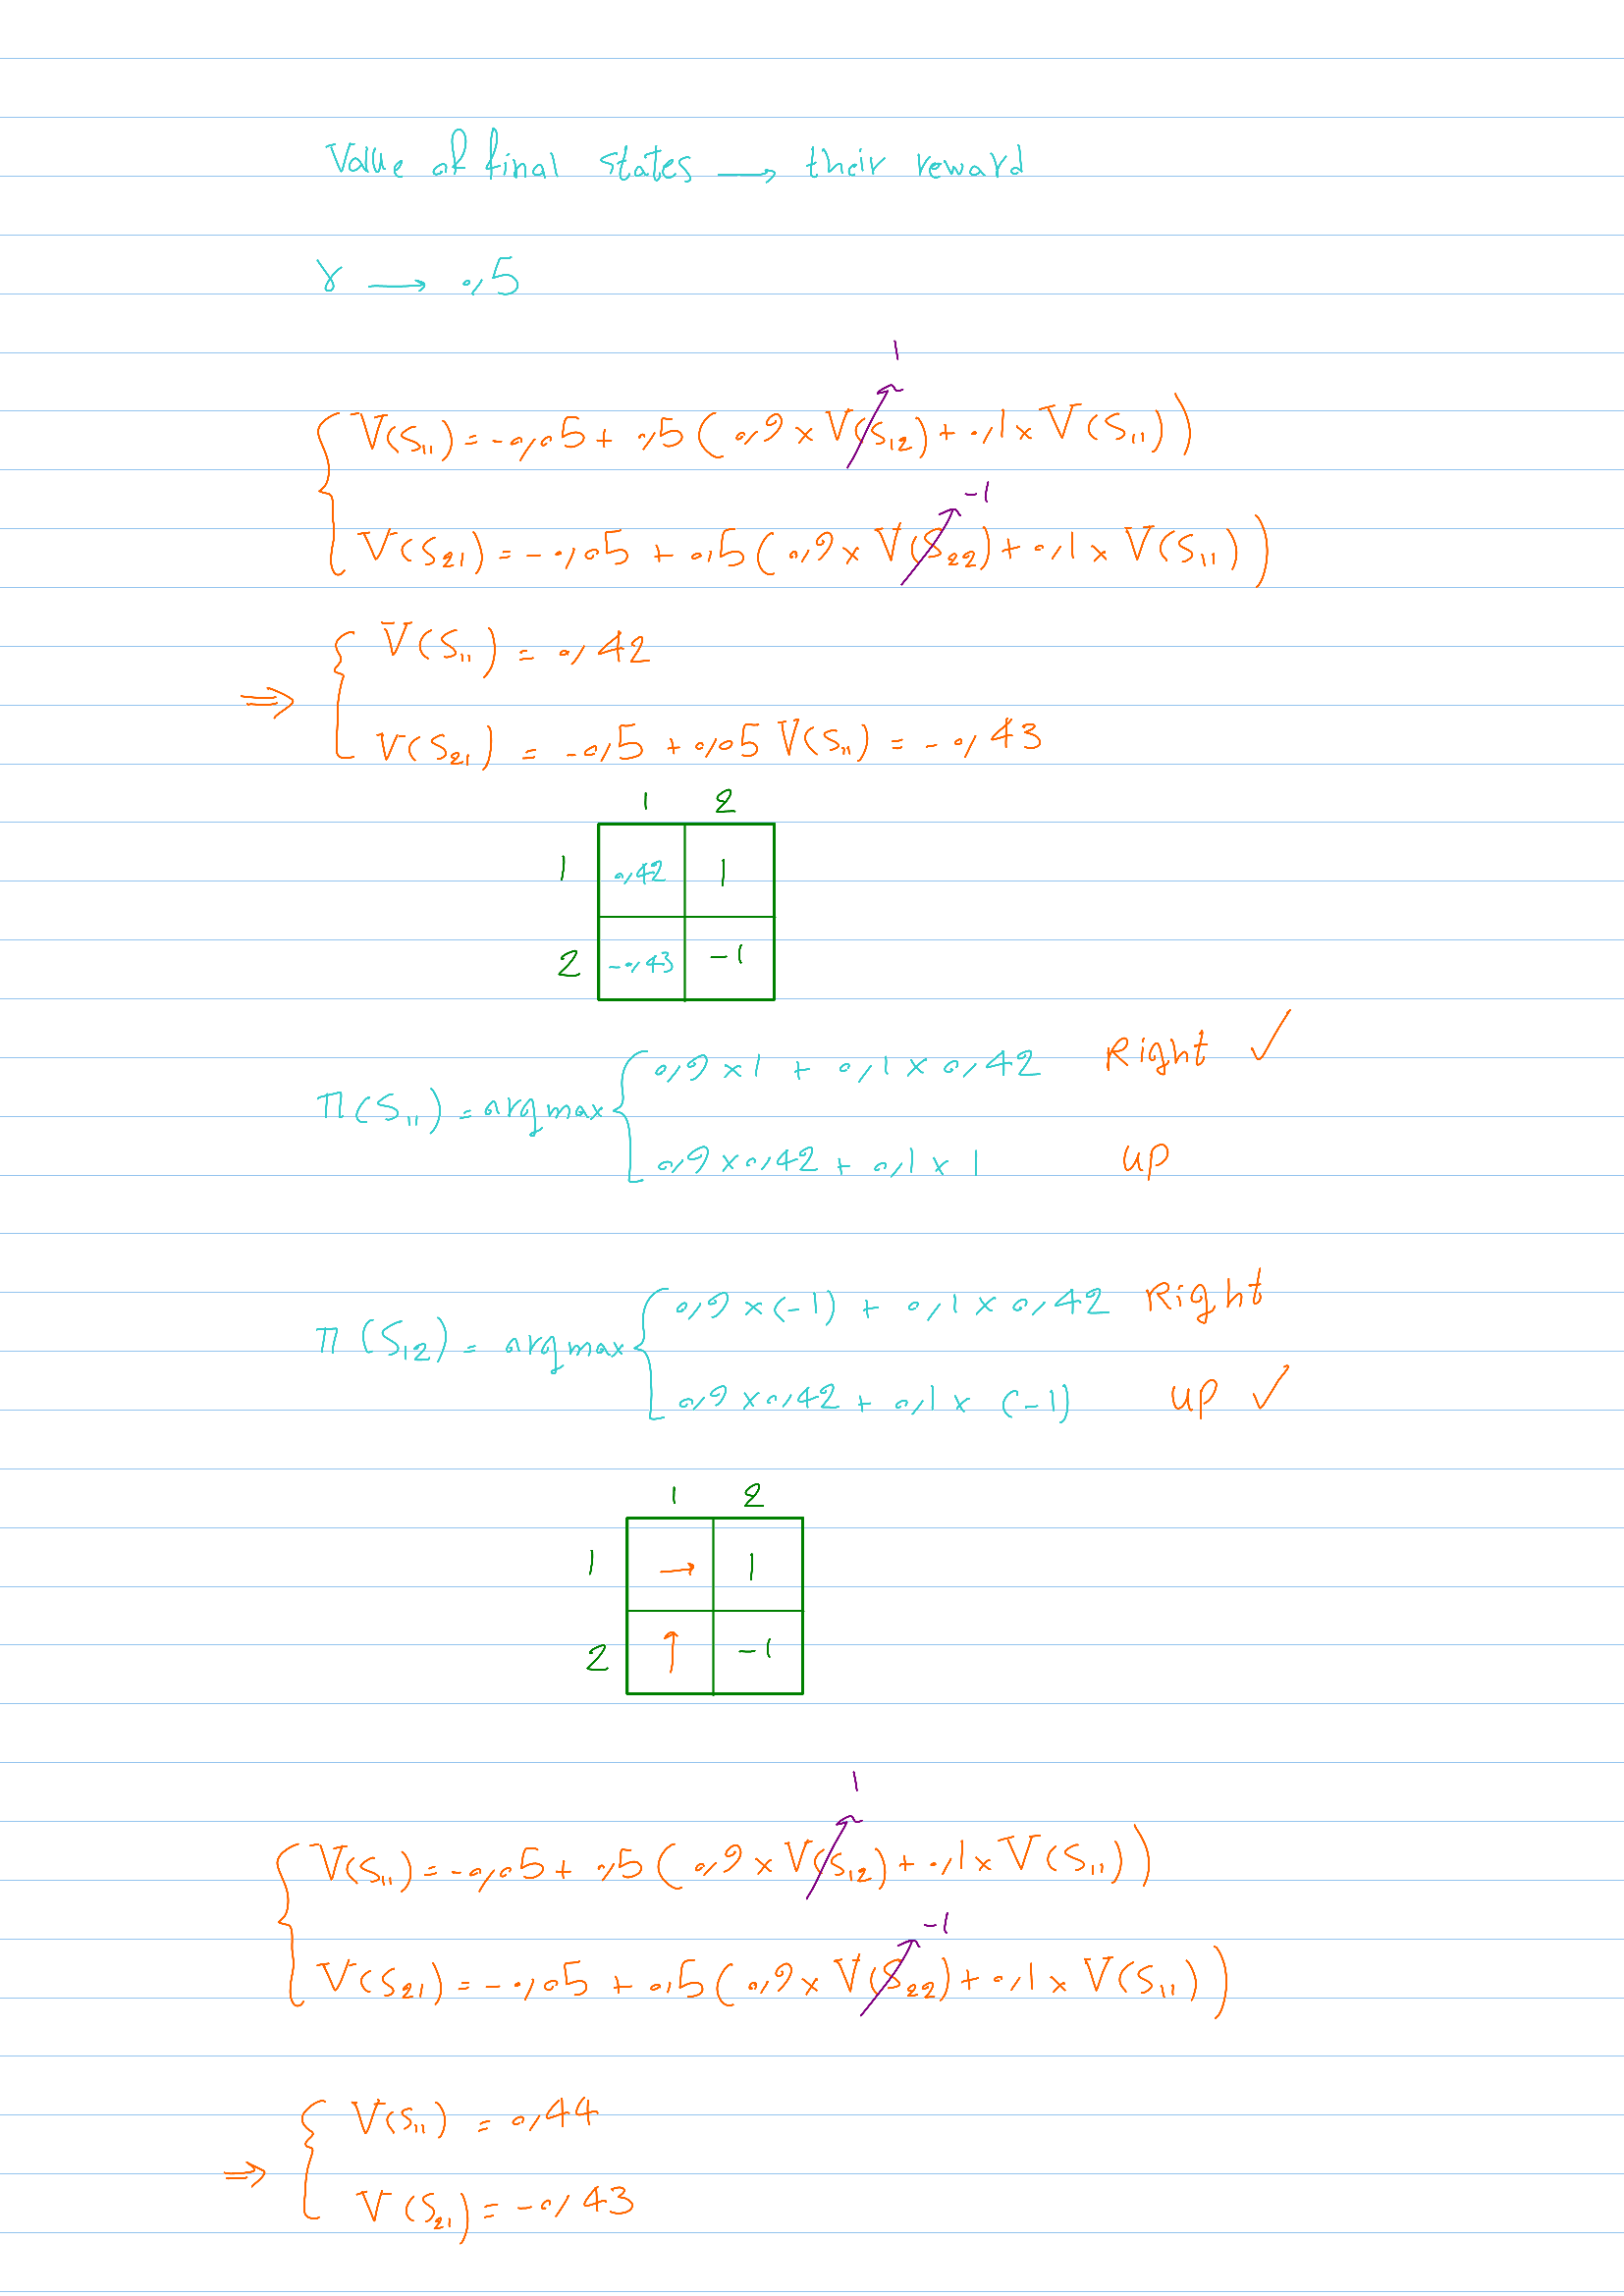

In [6]:
Image(filename = "/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q1/q1-part1_Page_2.png",width = 600,height = 1000)

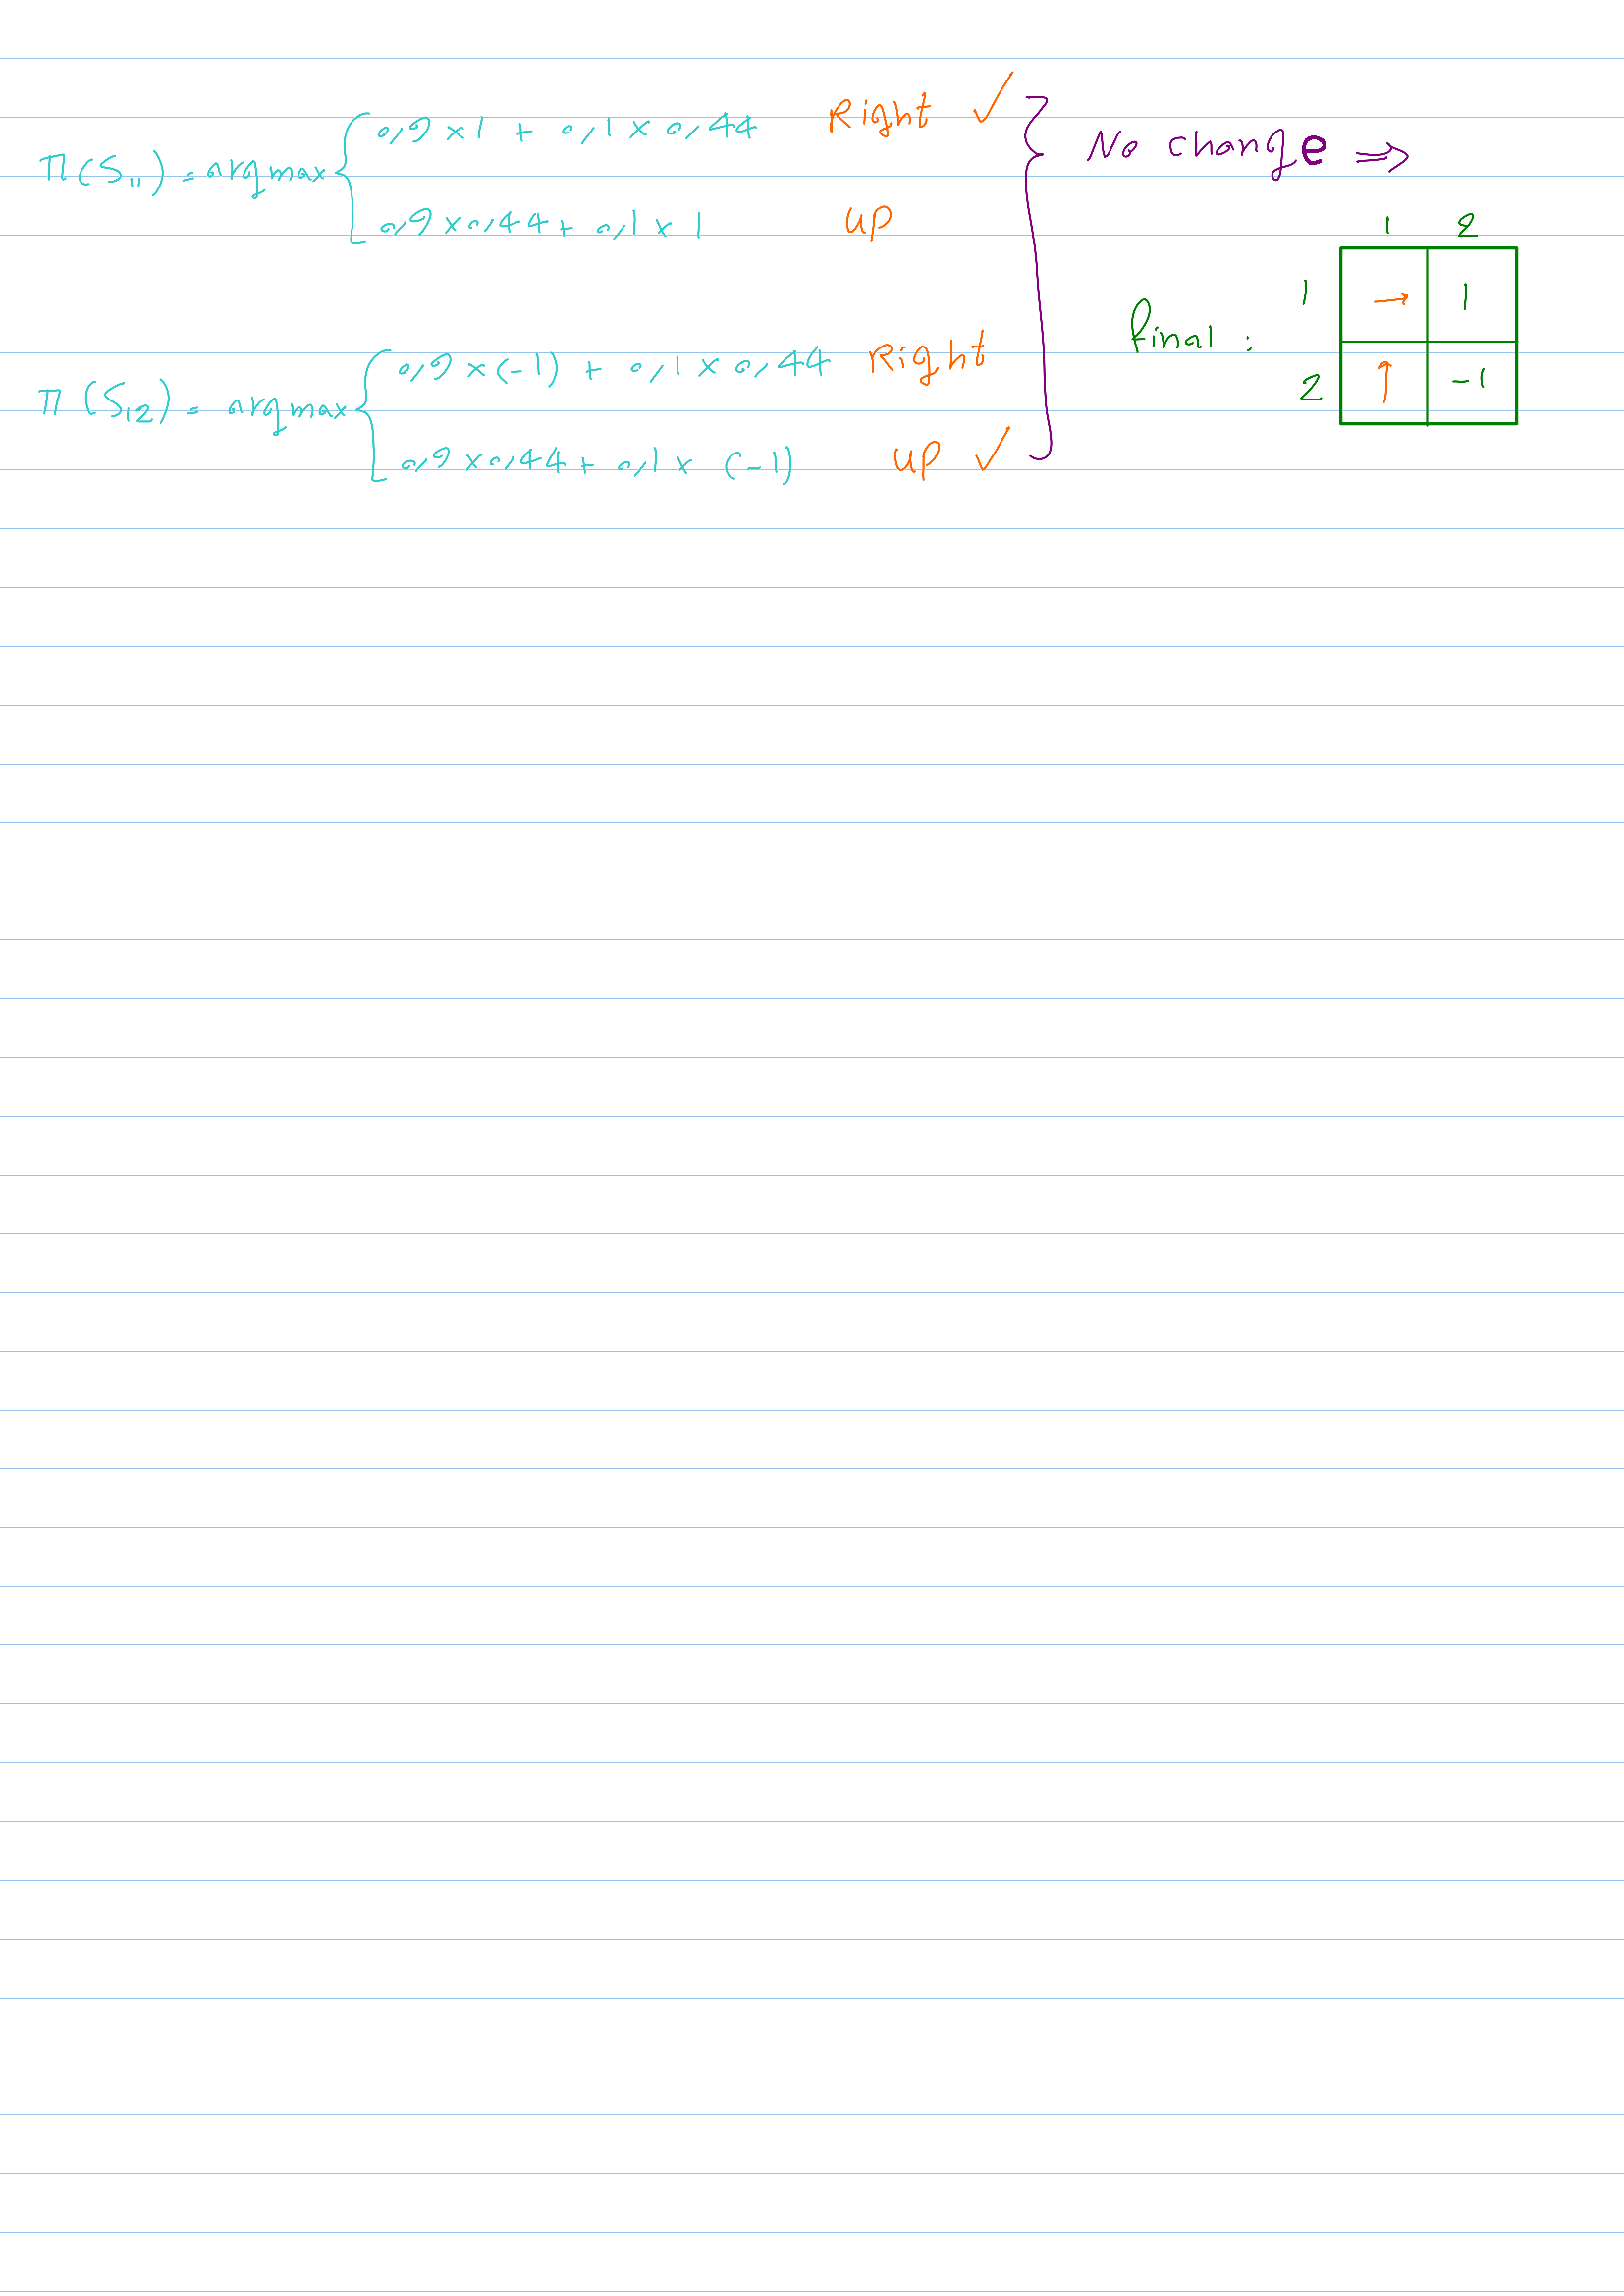

In [7]:
Image(filename = "/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q1/q1-part1_Page_3.png",width = 600,height = 1000)

Reefrences:

(1) Policy Iteration example: https://www.youtube.com/watch?v=ghbGffXAYfk

(2) Policy Iteration Explained: https://towardsdatascience.com/policy-iteration-in-rl-an-illustration-6d58bdcb87a7

## Section B: Code explanation And Hyperparameter Optimization

### Code Explanation

Here we take a closer look at the codes provided:

In [ ]:
# def train(self, batch_size):
#     minibatch = random.sample(self.memory, batch_size)
#     for state, action, reward, next_state, done in minibatch:
#       pass

In [ ]:
# for e in range(n_episodes):

#     state = env.reset()
#     state = np.reshape(state, [1, state_size])
#     done = False
#     time = 0

#     while not done:
#         action = agent.act(state)
#         next_state, reward, done, _ = env.step(action)
#         reward = reward if not done else -10
#         next_state = np.reshape(next_state, [1, state_size])
#         agent.remember(state, action, reward, next_state, done)
#         state = next_state

#         if done:
#             print("episode: {}/{}, score: {}, e: {:.2}".format(e, n_episodes-1, time, agent.epsilon))

#         time += 1
#         env.render()

#     if len(agent.memory) > batch_size:
#         agent.train(batch_size)

#     if e % 50 == 0:
#         agent.save(output_dir + "weights_" + '{:04d}'.format(e) + ".hdf5")

### **Hyperparameter optimization**

Now we use the code provided in the note book and try to optimize it's hyperparameters:

#### 1. Import dependencies

In [ ]:
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import Adam
from IPython.display import HTML
import os

#### 2. initialise environment

In [ ]:
env = gym.make('CartPole-v0') # initialise environment

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns 

In [ ]:
state_size = env.observation_space.shape[0]
state_size

4

#### 3. The agent can take two actions-right or left

In [ ]:
action_size = env.action_space.n
action_size

2

####6. DQNAgent

we changed the model by adding some arguments to make the NN model with different value for hyperparameters.

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, **kwargs):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000) # deque is like list and we can append elements to it.
        self.gamma = 0.95 # discount rate.
        self.epsilon = 1.0 # exploration rate: how much to act randomly.
        self.epsilon_decay = 0.99 # decrease number of random explorations as the agent's performance improves.
        self.epsilon_min = 0.01 # minimum amount of random exploration permitted.
        self.model = self._build_model(**kwargs) # This is a private method

    #==============================================================================================
    #Step 2
    #Here changed: we just define a new function to get the values of our neural net from
    #outside of the function

    def _build_model(self, num_layers, layers_units, activation, learning_rate):
        # neural net to approximate Q-value function.# Q is a f of s,a,theta
        model = Sequential()
        model.add(Dense(layers_units[0], activation=activation, input_dim=self.state_size))
        for i in range(num_layers - 1):
            model.add(Dense(layers_units[i+1], activation=activation))
        model.add(Dense(self.action_size, activation='linear')) # 2 actions. 2 output neurons: 0 and 1 (L/R)
        model.compile(loss='mse',
                      optimizer=Nadam(learning_rate=learning_rate)) # You can change this to Adam or other optimisers.
        return model

    #==================================================================================================

    #Step 3

    def remember(self, state, action, reward, next_state, done): # done means game is over or final or early termination.
        self.memory.append((state, action,
                            reward, next_state, done)) # list of previous experiences, enabling re-training later
     #=====================================================================================================

    # Step 4

    def train(self, batch_size): # method that trains NN with experiences sampled from memory
        minibatch = random.sample(self.memory, batch_size) # sample a minibatch from memory
        for state, action, reward, next_state, done in minibatch: # extract data for each minibatch sample
            target = reward # if done, then target = reward
            if not done: # if not done, then predict future discounted reward
                target = (reward +  # target here predicts the agent future rewards from the next state
                          self.gamma * # (target) = reward + (discount rate gamma) * # Using Bellman equation
                          np.amax(self.model.predict(next_state, verbose=0)[0])) # (maximum Q value based on future action a')
            target_f = self.model.predict(state, verbose=0) # map current state to our prediction of future discounted reward
            target_f[0][action] = target # We use the discounted future rewards based on the action that the agent took.
            self.model.fit(state, target_f, epochs=1, verbose=0) # using the NN to see which action is optimal,given s
        if self.epsilon > self.epsilon_min: # epochs=1 b/c no need to use recycle data. We can generate data by OpenAIGym
            self.epsilon *= self.epsilon_decay # Here we are adjusting the value of epsilon if the condition is true.

    def act(self, state):
        if np.random.rand() <= self.epsilon: # if acting randomly, take random action. take a random no from 0 to 1.
            return random.randrange(self.action_size) # The agent at this stage will explore
        act_values = self.model.predict(state, verbose=0) # if not acting randomly, predict reward value based on current state
        # As time progresses, the agent will take less random action=> the agent will exploit.
        # Our model will be used to predict the highest reward based on two actions.
        return np.argmax(act_values[0]) # pick the action that will give maximise the agent reward (left or right)

    #============================================================================================================

#### 7. Tuning hyper parameters

First we must install and import the keras tuner:


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


here we make a tuner class and overwrite the run_trial method of this class.

In [ ]:
import keras_tuner

class Tuner(keras_tuner.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # Build an agent using hyperparameters from the trial
        agent = self.build(trial.hyperparameters, *args)
        # Train the agent and return the score
        score = self.fit(agent, **kwargs)
        return score

    def build(self, hp, *args):
        # Determine the number of layers
        num_layers = hp.Int("num_layers", 1, 2)
        layers_units = []
        for i in range(num_layers):
            # Define units for each layer
            layers_units.append(hp.Int(f"units_{i+1}", min_value=12, max_value=36, step=12))

        # Create a DQNAgent with specified hyperparameters
        return DQNAgent(*args,
            num_layers=num_layers,
            layers_units=layers_units,
            activation=hp.Choice("activation", ["relu", "sigmoid", "tanh"]),
            learning_rate=hp.Float("learning_rate", min_value=0.001, max_value=0.01, sampling="log")
        )

    def fit(self, agent, n_episodes, batch_size):
        scores = []

        for e in range(n_episodes):  # Iterate over episodes of gameplay
            state = env.reset()  # Reset state and get four random states
            state = np.reshape(state, [1, state_size])  # Prepare state for the neural network

            done = False
            time = 0  # Goal: keep pole upright as long as possible
            while not done:
                action = agent.act(state)  # Choose an action based on the state
                next_state, reward, done, _ = env.step(action)  # Interact with environment
                reward = reward if not done else -10  # Update reward
                next_state = np.reshape(next_state, [1, state_size])  # Prepare next state
                agent.remember(state, action, reward, next_state, done)  # Store experience
                state = next_state  # Update current state for the next loop

                if done:  # If the game is over:
                    print(f"episode: {e}/{n_episodes-1}, score: {time}, e: {agent.epsilon:.2f}")
                time += 1

            scores.append(time - 1)

            if len(agent.memory) > batch_size:
                agent.train(batch_size)  # Train the agent using replayed experiences

        return sum(scores) / len(scores)  # Return average score


By the guids of keras-tuner official documentation, in order to keep our end-to-end workflow in one place, we might make a class and override Tuner.run_trial, which gives us full control of a trial. Each trial is an agent which has it's own hyper parameters, trained for many episodes. hyper parameters can change as bellow:

1. **Neural network layers:**

  - they varied between one or two layers with each layer having 12, 24 or 36  neurons.
2. **Activation functions:**
  - they can be sigmoid, tanh or relu
3. **Optimizer learning rate:**
  - It can range from 0.001 up to 0.01

Also, we define the score of agent as average as the average playing time in the last 10% of episodes.

#### 8. testing 5 different sets of hyper parameters

In [ ]:
tuner = Tuner(max_trials=5,
              overwrite=True,
              objective=keras_tuner.Objective('score', direction="max"))

tuner.search(state_size, action_size, n_episodes=200, batch_size=32)

Trial 5 Complete [00h 39m 48s]
score: 63.545

Best score So Far: 63.545
Total elapsed time: 02h 55m 10s


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 12, 'max_value': 36, 'step': 12, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 12, 'max_value': 36, 'step': 12, 'sampling': 'linear'}


#### 9. Tuning Summary

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="score", direction="max")

Trial 4 summary
Hyperparameters:
num_layers: 2
units_1: 24
activation: relu
learning_rate: 0.004071955149353072
units_2: 12
Score: 63.545

Trial 3 summary
Hyperparameters:
num_layers: 2
units_1: 24
activation: relu
learning_rate: 0.001235887014601505
units_2: 24
Score: 49.255

Trial 1 summary
Hyperparameters:
num_layers: 2
units_1: 12
activation: relu
learning_rate: 0.009870262965370202
units_2: 12
Score: 37.045

Trial 0 summary
Hyperparameters:
num_layers: 1
units_1: 12
activation: relu
learning_rate: 0.001
Score: 32.015

Trial 2 summary
Hyperparameters:
num_layers: 2
units_1: 36
activation: relu
learning_rate: 0.0028363173241025665
units_2: 24
Score: 12.355


References:

(1): keras-tuner, tuner class: https://keras.io/api/keras_tuner/tuners/base_tuner/

(2): deep Q-learning, UT AI spring 2024: https://colab.research.google.com/drive/16Zs4cKeZbuIB_5cJ2NGqKmrDFLDLAG1Y?usp=drive_open#scrollTo=4KAhqsA7zg9m

##**Section C: Frozen Lake Game**

###Problem Statement

***Environment:***

The environment is represented as a 4x4 grid.
* **States**: Each cell in the grid is a state.
* **Actions:** The agent can move in four directions (left, right, up, down).
* **Rewards:** The agent receives a reward of 1 when it reaches the goal (G) and 0 otherwise.
* **Holes:** If the agent steps into a hole (H), the episode ends and the agent receives a reward of 0.

***Objective:***

The goal is to find the optimal policy that maximizes the expected cumulative reward, which translates to finding the safest path from the start state (S) to the goal state (G).

First we must import the necessary libraries. random for random number calculations, gym for setting up the lake environment, numpy for numerical works and sequential, dense and adam for building a NN. we also use deque as we can set it's max size.

In [ ]:
import random
import gym
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import os

Here we setup the environment

In [ ]:
env = gym.make('FrozenLake-v1') # initialise environment

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Here we must set our state size. as you may know, we have 16 blocks in the frozen lake game and thus 16 states.

In [ ]:
state_size = env.observation_space.n
state_size

16

Now we set our action size. we can move in 4 direcions, so we have 4 actions.

In [ ]:
action_size = env.action_space.n
action_size

4

Here we specify our batch size and the number of games that we want the agent to play.

In [ ]:
batch_size = 32
n_episodes = 200

Here we define our agent class which will do everything needed for the agent to be done. each line is breifley explained in a comment.

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000) # deque is like list and we can append elements to it.
        self.gamma = 0.95 # discount rate.
        self.epsilon = 1.0 # exploration rate: how much to act randomly.
        self.epsilon_decay = 0.995 # decrease number of random explorations as the agent's performance improves.
        self.epsilon_min = 0.01 # minimum amount of random exploration permitted.
        self.learning_rate = 0.001 # learning rate.
        self.model = self._build_model() # This is a private method

    #==============================================================================================

    def _build_model(self):
        # neural net to approximate Q-value function.# Q is a f of s,a,theta
        model = Sequential()
        model.add(Dense(32, activation='relu', input_dim=self.state_size))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear')) # 4 actions.
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=self.learning_rate)) # You can change this to Adam or other optimisers.
        return model

    #==================================================================================================


    def remember(self, state, action, reward, next_state, done): # done means game is over or final or early termination.
        self.memory.append((state, action,
                            reward, next_state, done)) # list of previous experiences, enabling re-training later
     #=====================================================================================================

    def train(self, batch_size): # method that trains NN with experiences sampled from memory
        minibatch = random.sample(self.memory, batch_size) # sample a minibatch from memory
        for state, action, reward, next_state, done in minibatch: # extract data for each minibatch sample
            target = reward # if done, then target = reward
            if not done: # if not done, then predict future discounted reward
                target = (reward +  # target here predicts the agent future rewards from the next state
                          self.gamma * # (target) = reward + (discount rate gamma) * # Using Bellman equation
                          np.amax(self.model.predict(next_state)[0])) # (maximum Q value based on future action a')
            target_f = self.model.predict(state) # map current state to our prediction of future discounted reward
            target_f[0][action] = target # We use the discounted future rewards based on the action that the agent took.
            self.model.fit(state, target_f, epochs=1, verbose=0) # using the NN to see which action is optimal,given s
        if self.epsilon > self.epsilon_min: # epochs=1 b/c no need to use recycle data. We can generate data by OpenAIGym
            self.epsilon *= self.epsilon_decay # Here we are adjusting the value of epsilon if the condition is true.

    def act(self, state):
        if np.random.rand() <= self.epsilon: # if acting randomly, take random action. take a random no from 0 to 1.
            return random.randrange(self.action_size) # The agent at this stage will explore
        act_values = self.model.predict(state) # if not acting randomly, predict reward value based on current state
        # As time progresses, the agent will take less random action=> the agent will exploit.
        # Our model will be used to predict the highest reward based on two actions.
        return np.argmax(act_values[0]) # pick the action that will give maximise the agent reward (left or right)

Int this part we build the agent and train our model to find a path to goal. again each line of code is explained by a comment.

In [ ]:
agent = DQNAgent(state_size, action_size)

total_wins = 0

for e in range(n_episodes): # iterate over episodes of gameplay

    state = env.reset() # reset state and environment
    state = np.identity(state_size)[state:state+1] # To pass this to the NN.

    done = False
    total_reward = 0 # the goal is to make it to the end alive
    while not done:
    # This while loop ends if we get to 200 timesteps or we lose or win.
        action = agent.act(state) # Given the state, the agent takes an action (move cart left or right).
        next_state, reward, done, _ = env.step(action) # agent interacts with env, gets feedback; 4 state data points.
        # reward = reward if not done else -10 # reward +1 for each additional frame with pole upright and -10 for ending the game.
        next_state = np.identity(state_size)[next_state:next_state+1] # To pass this to the NN.
        agent.remember(state, action, reward, next_state, done) # To remember the previous timestep's state, actions, reward, etc.
        state = next_state # set current state to the current next state for the next while loop
        if done: # if episode ends:
            print("episode: {}/{}, win?: {}, epsilon: {:.2}" # print the episode's score and agent's epsilon
                  .format(e, n_episodes-1, bool(reward), agent.epsilon))
            total_wins += reward

        #env.render()

    if len(agent.memory) > batch_size:
        agent.train(batch_size) # train the agent by replaying the experiences of the episode
    if e % 10 == 0:
        print(f"wins after {e} episodes: {total_wins}")

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step
episode: 129/199, win?: False, epsilon: 0.53
1/1 [==============================] - 0s 17ms/step
episode: 130/199, win?: False, epsilon: 0.53
1/1 [==============================] - 0s 23ms/step
wins after 130 episodes: 3.0
1/1 [==============================] - 0s 28ms/step
episode: 131/199, win?: False, epsilon: 0.53
1/1 [==============================] - 0s 23ms/step
episode: 132/199, win?: False, epsilon: 0.53
1/1 [==============================] - 0s 25ms/step
episode: 133/199, win?: False, epsilon: 0.52
1/1 [==============================] - 0s 56ms/step
episode: 134/199, win?: False, epsilon: 0.52
1/1 [==============================] - 0s 19ms/step
episode: 135/199, win?: False, epsilon: 0.52
1/1 [==============================] - 0s 22ms/step
episode: 136/199, win?: False, epsilon: 0.52
1/1 [==============================] - 0s 23ms/step
episode: 137/199, win?: False, epsilon: 

References:

(1) gym frozen lake: https://www.gymlibrary.dev/environments/toy_text/frozen_lake/

(2): deep Q-learning, UT AI spring 2024: https://colab.research.google.com/drive/16Zs4cKeZbuIB_5cJ2NGqKmrDFLDLAG1Y?usp=drive_open#scrollTo=4KAhqsA7zg9m

#Qestion 2

## Section A: Long Short-Term Memory (LSTM): Mathematical Intuition and Example

### Introduction to RNN and LSTM

Recurrent Neural Networks (RNNs) are designed to process sequences of data by maintaining a hidden state that captures information about previous elements in the sequence. However, standard RNNs suffer from the vanishing gradient problem, making it difficult to capture long-term dependencies. Long Short-Term Memory (LSTM) networks were introduced to address this issue by incorporating gating mechanisms that regulate the flow of information.


Mounted at /content/drive


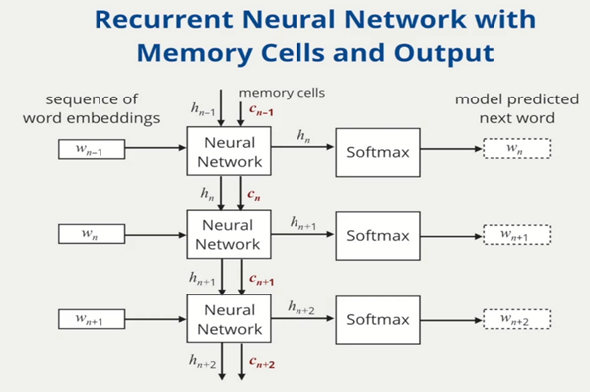

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from IPython.display import Image
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q2/overall-lstm.png")

#Source: introduction to machine learning, duke university.


### LSTM Architecture

An LSTM unit consists of several components:
- **Cell State ($(C_t$))**: The long-term memory of the network.
- **Hidden State ($(h_t$))**: The short-term memory or output at each time step.
- **Forget Gate ($(f_t$))**: Decides what information to discard from the cell state.
- **Input Gate ($(i_t$))**: Decides what new information to add to the cell state.
- **Output Gate ($(o_t$))**: Decides what information to output from the hidden state.

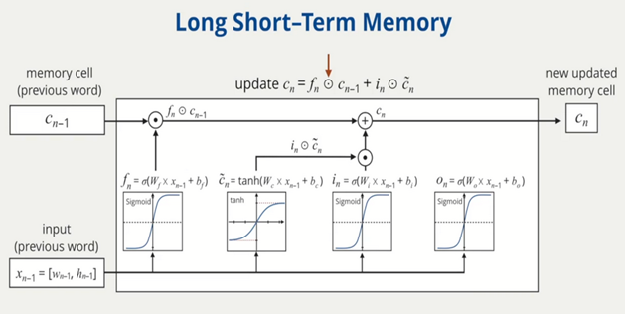

In [ ]:
from IPython.display import Image
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q2/inside-block-lstm.png",height = 500, width = 850)

#Source: introduction to machine learning, duke university.

### Mathematical Formulation

Let's denote:
- $(x_t$): Input at time step $(t$)
- $(h_{t-1}$): Hidden state from the previous time step
- $(C_{t-1}$): Cell state from the previous time step
- $(W$) and $(b$): Weights and biases for the gates

The equations governing the LSTM are as follows:

1. **Forget Gate**:

   $[
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $]

   Here, $(\sigma$) is the sigmoid activation function.

2. **Input Gate**:

   $[
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $]

   $[
   \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
   $]

   $[
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $]

   Here, $(\tanh$) is the hyperbolic tangent function.

3. **Output Gate**:
   $[
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $]

   $[
   h_t = o_t \cdot \tanh(C_t)
   $]

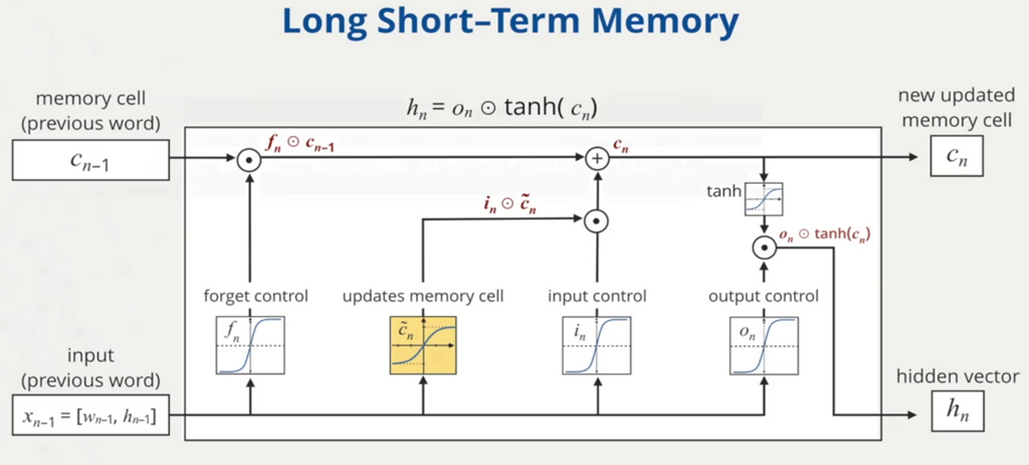

In [ ]:
from IPython.display import Image
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q2/block-lstm.png",height = 500, width = 850)

#Source: introduction to machine learning, duke university.

What we mean by multiply:

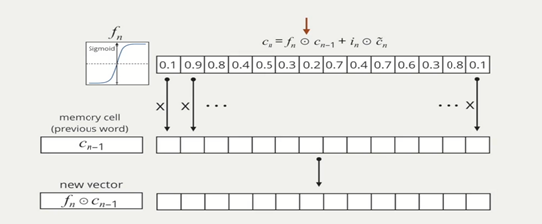

In [ ]:
from IPython.display import Image
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q2/multiply-lstm.png",height = 500, width = 850)

#Source: introduction to machine learning, duke university.

### Example

Let's walk through an example with a sequence of inputs: $(x_1, x_2, x_3$).

1. **Initialization**:

   - $(h_0 = 0$)
   - $(C_0 = 0$)

2. **Time Step $(t=1$)**:
   - Input: $(x_1$)
   - Calculate forget gate: $(f_1 = \sigma(W_f \cdot [0, x_1] + b_f)$)
   - Calculate input gate: $(i_1 = \sigma(W_i \cdot [0, x_1] + b_i)$)
   - Calculate candidate cell state: $(\tilde{C}_1 = \tanh(W_C \cdot [0, x_1] + b_C)$)
   - Update cell state: $(C_1 = f_1 \cdot 0 + i_1 \cdot \tilde{C}_1 = i_1 \cdot \tilde{C}_1$)
   - Calculate output gate: $(o_1 = \sigma(W_o \cdot [0, x_1] + b_o)$)
   - Update hidden state: $(h_1 = o_1 \cdot \tanh(C_1)$)

3. **Time Step $(t=2$)**:
   - Input: $(x_2$)
   - Calculate forget gate: $(f_2 = \sigma(W_f \cdot [h_1, x_2] + b_f)$)
   - Calculate input gate: $(i_2 = \sigma(W_i \cdot [h_1, x_2] + b_i)$)
   - Calculate candidate cell state: $(\tilde{C}_2 = \tanh(W_C \cdot [h_1, x_2] + b_C)$)
   - Update cell state: $(C_2 = f_2 \cdot C_1 + i_2 \cdot \tilde{C}_2$)
   - Calculate output gate: $(o_2 = \sigma(W_o \cdot [h_1, x_2] + b_o)$)
   - Update hidden state: $(h_2 = o_2 \cdot \tanh(C_2)$)

4. **Time Step $(t=3$)**:
   - Input: $(x_3$)
   - Calculate forget gate: $(f_3 = \sigma(W_f \cdot [h_2, x_3] + b_f)$)
   - Calculate input gate: $(i_3 = \sigma(W_i \cdot [h_2, x_3] + b_i)$)
   - Calculate candidate cell state: $(\tilde{C}_3 = \tanh(W_C \cdot [h_2, x_3] + b_C)$)
   - Update cell state: $(C_3 = f_3 \cdot C_2 + i_3 \cdot \tilde{C}_3$)
   - Calculate output gate: $(o_3 = \sigma(W_o \cdot [h_2, x_3] + b_o)$)
   - Update hidden state: $(h_3 = o_3 \cdot \tanh(C_3)$)



### Example with Numerical Values

#### Initialization

1. **Weights and Biases**:

   $[
   W_f = W_i = W_C = W_o = \begin{bmatrix} 0.5 & 0.5 & 0.5 & 0.5 \\ 0.5 & 0.5 & 0.5 & 0.5 \end{bmatrix}, \quad b_f = b_i = b_C = b_o = \begin{bmatrix}  0 \\ 0  \end{bmatrix}
   $]

2. **Initial Hidden State and Cell State**:

   $[
   h_0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \quad C_0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}
   $]

3. **Inputs**:

   $[
   w_1 = \begin{bmatrix} 1 \\ 0 \end{bmatrix}, \quad w_2 = \begin{bmatrix} 0 \\ 1 \end{bmatrix}, \quad w_3 = \begin{bmatrix} 1 \\ 1 \end{bmatrix}
   $]

#### Time Step \(t=1\)

1. **Input**:

   $[
   x_1 = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0  \end{bmatrix}
   $]

2. **Forget Gate**:

   $[
   f_1 = \sigma(W_f \cdot [h_0, x_1] + b_f) = \sigma \left( \begin{bmatrix} 0.5 & 0.5 & 0.5 & 0.5 \\ 0.5 & 0.5 & 0.5 & 0.5 \end{bmatrix} \cdot \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix} \right) = \sigma \left( \begin{bmatrix} 0 \\ 0.5 \end{bmatrix} \right) = \begin{bmatrix}  0 \\ 0.62245933 \end{bmatrix}
   $]

3. **Input Gate**:

   $[
   i_1 = \sigma(W_i \cdot [h_0, x_1] + b_i) = \sigma \left( \begin{bmatrix} 0.5 & 0.5 & 0.5 & 0.5 \\ 0.5 & 0.5 & 0.5 & 0.5 \end{bmatrix} \cdot \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix} \right) = \sigma \left( \begin{bmatrix} 0 \\ 0.5 \end{bmatrix} \right) = \begin{bmatrix}  0 \\ 0.62245933 \end{bmatrix}
   $]

4. **Candidate Cell State**:

   $[
   \tilde{C}_1 = \tanh(W_C \cdot [h_0, x_1] + b_C) = \tanh \left( \begin{bmatrix} 0.5 & 0.5 & 0.5 & 0.5 \\ 0.5 & 0.5 & 0.5 & 0.5 \end{bmatrix} \cdot \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix} \right) = \tanh \left( \begin{bmatrix} 0 \\ 0.5 \end{bmatrix} \right) = \begin{bmatrix}  0 \\ 0.46211716  \end{bmatrix}
   $]

5. **Cell State**:

   $[
   C_1 = f_1 \cdot C_0 + i_1 \cdot \tilde{C}_1 = \begin{bmatrix} 0 \\ 0.62245933 \end{bmatrix} \cdot \begin{bmatrix}  0 \\ 0 \end{bmatrix} + \begin{bmatrix}  0 \\ 0.62245933  \end{bmatrix} \cdot \begin{bmatrix}   0 \\ 0.46211716  \end{bmatrix} = \begin{bmatrix}  0 \\ 0.28718524  \end{bmatrix}
   $]

6. **Output Gate**:

   $[
   o_1 = \sigma(W_o \cdot [h_0, x_1] + b_o) = \sigma \left( \begin{bmatrix} 0.5 & 0.5 & 0.5 & 0.5 \\ 0.5 & 0.5 & 0.5 & 0.5 \end{bmatrix} \cdot \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix} \right) = \sigma \left( \begin{bmatrix} 0 \\ 0.5 \end{bmatrix} \right) = \begin{bmatrix}  0 \\ 0.62245933 \end{bmatrix}$

7. **Hidden State**:

   $[
   h_1 = o_1 \cdot \tanh(C_1) = \begin{bmatrix}  0 \\ 0.62245933  \end{bmatrix} \cdot \tanh \left( \begin{bmatrix}  0 \\ 0.28718524  \end{bmatrix} \right) = \begin{bmatrix}  0 \\ 0.62245933  \end{bmatrix} \cdot \begin{bmatrix}  0 \\ 0.27969371  \end{bmatrix} = \begin{bmatrix}  0 \\ 0.17369373  \end{bmatrix}
   $]

#### Time Step \(t=2\)

1. **Input**:

   $[
   x_2 = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \end{bmatrix}
   $]

2. **Forget Gate**: $...$

### Back Propegation:

- **Weights and Biases**:
  $[
  W_f = W_i = W_C = W_o = \begin{bmatrix} 0.5 & 0.5 & 0.5 & 0.5 \\ 0.5 & 0.5 & 0.5 & 0.5 \end{bmatrix}, \quad b_f = b_i = b_C = b_o = \begin{bmatrix} 0 \\ 0  \end{bmatrix}
  $]

- **Initial Hidden State and Cell State**:
  $[
  h_0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \quad C_0 = \begin{bmatrix} 0 \\ 0  \end{bmatrix}
  $]

- **Inputs**:
  $[
  x_1 = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}
  $]

- **Outputs from Forward Pass at \( t=1 \)**:
  $[
  f_1 = \begin{bmatrix}  0 \\ 0.62245933  \end{bmatrix}, \quad i_1 = \begin{bmatrix}  0 \\ 0.62245933  \end{bmatrix}, \quad \tilde{C}_1 = \begin{bmatrix}  0 \\ 0.46211716  \end{bmatrix}, \quad C_1 = \begin{bmatrix}  0 \\ 0.28718524  \end{bmatrix}, \quad o_1 = \begin{bmatrix}  0 \\ 0.62245933  \end{bmatrix}, \quad h_1 = \begin{bmatrix}  0 \\ 0.17369373  \end{bmatrix}
  $]

### Back Propagation Through Time (BPTT) Step:

To compute gradients for the LSTM parameters $( W_f, W_i, W_C, W_o $) and $( b_f, b_i, b_C, b_o $), we proceed as follows:

1. **Output Gate $( o_1 $) and Hidden State $( h_1 $) Gradient Calculation**:
   $[
   \frac{\partial h_1}{\partial o_1} = \tanh(C_1) = \begin{bmatrix}  0 \\ 0.27969371  \end{bmatrix}
   $]
   $[
   \frac{\partial h_1}{\partial o_1} = \begin{bmatrix} 0 \\ 0.27969371  \end{bmatrix} \quad \text{(element-wise multiplication)}
   $]

2. **Gradient of Loss $( \mathcal{L} $) w.r.t. $( h_1 $)**:
   Let's assume $( \frac{\partial \mathcal{L}}{\partial h_1} = \begin{bmatrix} \frac{\partial \mathcal{L}}{\partial h_1[1]} \\ \frac{\partial \mathcal{L}}{\partial h_1[2]}  \end{bmatrix} $).

3. **Gradient of Loss $( \mathcal{L} $) w.r.t. $( o_1 $)**:
   $[
   \frac{\partial \mathcal{L}}{\partial o_1} = \frac{\partial \mathcal{L}}{\partial h_1} \cdot \frac{\partial h_1}{\partial o_1} = \begin{bmatrix} \frac{\partial \mathcal{L}}{\partial h_1[1]} \\ \frac{\partial \mathcal{L}}{\partial h_1[2]}  \end{bmatrix} \cdot \begin{bmatrix}  0 \\ 0.27969371  \end{bmatrix} = \begin{bmatrix}  0 \\ \frac{\partial \mathcal{L}}{\partial h_1[2]} \cdot 0.27969371  \end{bmatrix}
   $]

4. **Gradient of Loss $( \mathcal{L} $) w.r.t. $( C_1 $)**:
   $[
   \frac{\partial \mathcal{L}}{\partial C_1} = \frac{\partial \mathcal{L}}{\partial h_1} \cdot o_1 \cdot (1 - \tanh^2(C_1)) = \begin{bmatrix} \frac{\partial \mathcal{L}}{\partial h_1[1]} \\ \frac{\partial \mathcal{L}}{\partial h_1[2]}  \end{bmatrix} \cdot \begin{bmatrix}  0 \\ 0.62245933  \end{bmatrix} \cdot (1 - \begin{bmatrix}  0 \\ 0.28718524  \end{bmatrix}) = \begin{bmatrix}  0 \\ \frac{\partial \mathcal{L}}{\partial h_1[2]} \cdot 0.36528372  \end{bmatrix}
   $]

5. **Gradient of Loss $( \mathcal{L} $) w.r.t. $( f_1 $), $( i_1 $), $( \tilde{C}_1 $)**:
   - Compute $( \frac{\partial \mathcal{L}}{\partial f_1} $), $( \frac{\partial \mathcal{L}}{\partial i_1} $), and $( \frac{\partial \mathcal{L}}{\partial \tilde{C}_1} $) similarly using $( C_0 $), $( \tilde{C}_1 $), and $( i_1 $).

6. **Gradient of Loss $( \mathcal{L} $) w.r.t. $( W_f, W_i, W_C, W_o $) and $ b_f, b_i, b_C, b_o $)**:
   - Update each weight matrix $( W $) and bias vector $( b $) using the computed gradients and a learning rate.


Refrences:

(1) introduction to machinge learning, duke university, Coursera.

(2) Stuart Russell and Peter Norvig - Artificial Intelligence_ A Modern Approach-Pearson (2020)

<hr>

## Section B: Explaining And improving RNN, GRU And LSTM Models.

#**1.Import libraries**

In [ ]:
import keras
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


from zipfile import ZipFile
import os

from google.colab import drive
drive.mount('/content/drive')

with ZipFile('/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q2/jena_climate_2009_2016.zip','r') as zipObj:
  zipObj.extractall('/content/drive/MyDrive/RNN-LSTMN')



Mounted at /content/drive


#**2.Import our data.**

In [ ]:
csv_path = "/content/drive/MyDrive/RNN-LSTMN/jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

#**3. The next step is to delete all columns other than the temperature, as we are building a univariate model. Keeping only the temperature data.**

In [ ]:
df = df[['T (degC)']]

#**4. We apply the min-max scaler.**

In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['T'])

# **5. We prepare our data and convert the list of lists to numpy array.We need to split the data into a shape in which we have sequences of past data and sequences of future data. We want to predict 72 steps into the future, and we’ll use 3*72 steps into the past. This is an arbitrary choice. You can try out using more or less past data.**

In [ ]:
ylist = list(df['T'])

#change
n_future = 64
n_past = 4*64
total_period = 5*64

idx_end = len(ylist)
idx_start = idx_end - total_period

X_new = []
y_new = []
while idx_start > 0:
  x_line = ylist[idx_start:idx_start+n_past]
  y_line = ylist[idx_start+n_past:idx_start+total_period]

  X_new.append(x_line)
  y_new.append(y_line)

  idx_start = idx_start - 1



X_new = np.array(X_new)
y_new = np.array(y_new)

#**6.We do train test split.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.1, random_state=42)

In [ ]:
X_train.shape

(378207, 256)

#**7.It takes a long time to run this model. The batch size of 2000 is provided for demonstration purposes. But you need to put a much smaller batch size. Note that The SimpleRNN layer needs an input format that is 3D, and the shape has to correspond to (n_samples, n_timesteps, n_features). This can be obtained using reshape.**

In [ ]:
#change
batch_size = 500

n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1

X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )

X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )

In [ ]:
# from IPython.display import Image
# Image(filename='/content/drive/MyDrive/RNN-LSTM/RNN-NB-1.jpg', width=900,height=900)

#**8.We parameterize a small network with SimpleRNN.**
Line 1: -------
Line 2: -------
Line 3:-------

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 256, 8)            80        
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 256, 8)            136       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 64)                576       
                                                                 
Total params: 928 (3.62 KB)
Trainable params: 928 (3.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
606/606 [==============================] - 128s 206ms/step - loss: 0.0502 - mean_absolute_error: 0.0502 - val_loss: 0.0422 - val_mean_absolute_er

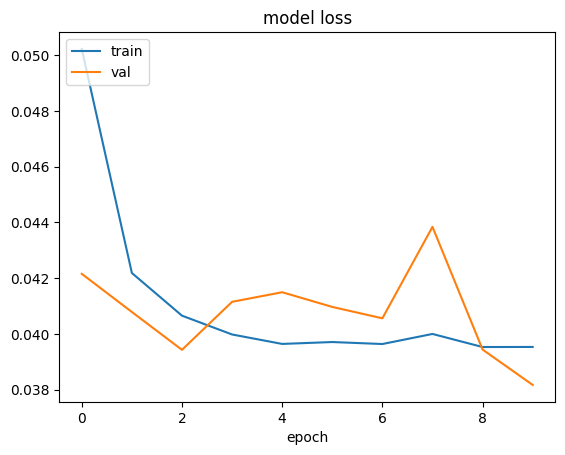

In [ ]:
random.seed(42)

simple_model = Sequential([
  SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
  SimpleRNN(8, activation='tanh', return_sequences = True),
  SimpleRNN(8, activation='tanh'),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          #change
          epochs=10,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)



plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(r2_score(preds, y_test))

0.7820056497588846


In [ ]:
# from IPython.display import Image
# Image(filename='/content/drive/MyDrive/RNN-LSTM/RNN-NB-2.jpg', width=900,height=900)

#**9.A simple architecture with 1 Gated Recurrent Unit (GRU) layer.**

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 64)                576       
                                                                 
Total params: 840 (3.28 KB)
Trainable params: 840 (3.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
606/606 [==============================] - 93s 149ms/step - loss: 0.0453 - mean_absolute_error: 0.0453 - val_loss: 0.0439 - val_mean_absolute_error: 0.0439
Epoch 2/5
606/606 [==============================] - 90s 148ms/step - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 3/5
606/606 [==============================] - 86s 142ms/step - loss: 0.0277 - mea

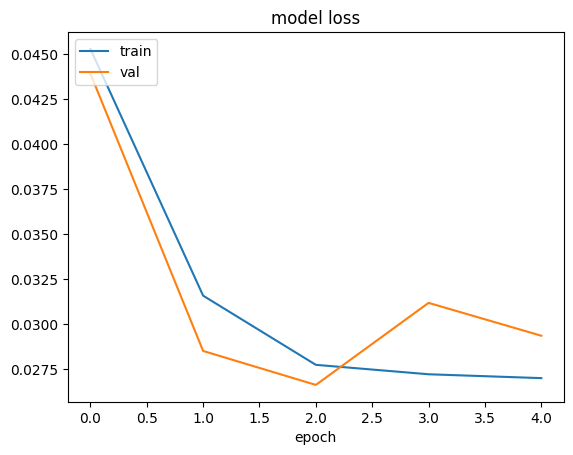

In [ ]:
random.seed(42)
from tensorflow.keras.layers import GRU

simple_model = Sequential([
   GRU(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)



plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(r2_score(preds, y_test))

0.9198416694490721


#**10.This is a  more complex network with three layers of Gated Recurrent Unit (GRU).**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256, 10)           390       
                                                                 
 gru_1 (GRU)                 (None, 256, 10)           660       
                                                                 
 gru_2 (GRU)                 (None, 10)                660       
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
Total params: 2414 (9.43 KB)
Trainable params: 2414 (9.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
606/606 [==============================] - 325s 520ms/step - loss: 0.0868 - mean_absolute_error: 0.0868 - val_loss: 0.0442 - val_mean_absolute_err

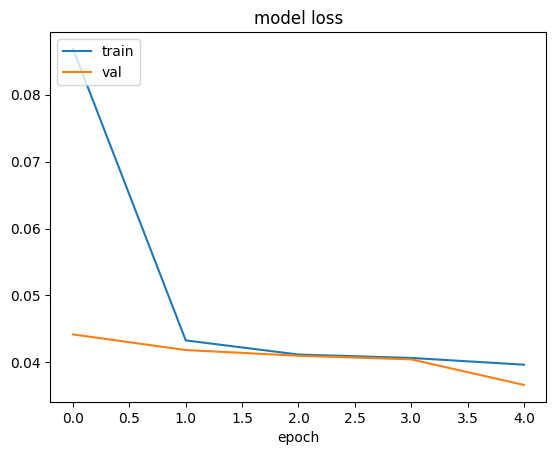

In [ ]:
random.seed(42)
from tensorflow.keras.layers import GRU

simple_model = Sequential([
   GRU(10, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
    GRU(10, activation='tanh', return_sequences=True),
    GRU(10, activation='tanh'),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)



plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(r2_score(preds, y_test))

0.823129492829044


#**NOTE 2: In Part II, you must explain all the codes line by line. You should also improve the Train Score: 14.93 RMSE and Test Score: 46.19 RMSE of the model.**

#**Part II**
#**In this part, we will employ LSTM.This section uses the stock market data(SP500).**

#**1. Import libraries.**

In [ ]:
import pandas
import matplotlib.pyplot as plt
import numpy
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. We normalize the dataset and do train and test split.**

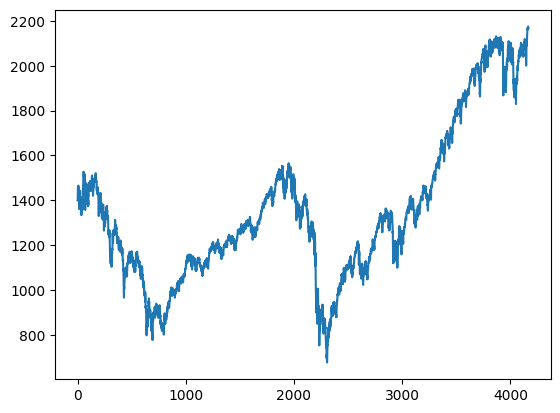

2791 1376


In [ ]:
dataset = pandas.read_csv('/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q2/sp500.csv', usecols=[0], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

In [ ]:
print(dataset)

[[0.48240909]
 [0.48420417]
 [0.48509838]
 ...
 [0.99562893]
 [0.99609603]
 [0.99436106]]


# **3. We convert an array of values into a timeseries data.**

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
#change
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX.shape

(2785, 5)

# **4. We reshape input to be [samples, time steps, features].**

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# **5.We create and fit the LSTM network.**

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=2)

Epoch 1/100
279/279 - 3s - loss: 0.0111 - 3s/epoch - 10ms/step
Epoch 2/100
279/279 - 1s - loss: 3.0804e-04 - 984ms/epoch - 4ms/step
Epoch 3/100
279/279 - 1s - loss: 2.1761e-04 - 1s/epoch - 4ms/step
Epoch 4/100
279/279 - 1s - loss: 2.0936e-04 - 939ms/epoch - 3ms/step
Epoch 5/100
279/279 - 1s - loss: 2.0182e-04 - 1s/epoch - 4ms/step
Epoch 6/100
279/279 - 1s - loss: 1.9254e-04 - 990ms/epoch - 4ms/step
Epoch 7/100
279/279 - 1s - loss: 1.8498e-04 - 664ms/epoch - 2ms/step
Epoch 8/100
279/279 - 1s - loss: 1.7504e-04 - 708ms/epoch - 3ms/step
Epoch 9/100
279/279 - 1s - loss: 1.6592e-04 - 654ms/epoch - 2ms/step
Epoch 10/100
279/279 - 1s - loss: 1.5937e-04 - 687ms/epoch - 2ms/step
Epoch 11/100
279/279 - 1s - loss: 1.5489e-04 - 684ms/epoch - 2ms/step
Epoch 12/100
279/279 - 1s - loss: 1.5010e-04 - 669ms/epoch - 2ms/step
Epoch 13/100
279/279 - 1s - loss: 1.4441e-04 - 728ms/epoch - 3ms/step
Epoch 14/100
279/279 - 1s - loss: 1.4414e-04 - 810ms/epoch - 3ms/step
Epoch 15/100
279/279 - 1s - loss: 1.3746e

#**6.We rescale predicted values and compute the root mean squared error.**

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

43/43 [==============================] - 0s 2ms/step
Train Score: 15.77 RMSE
Test Score: 21.96 RMSE


# **7. We shift train and test predictions for plotting and plot baseline and predictions.The part in orange is the training data, the part in blue is the test data, and the part in green is the predicted output.**

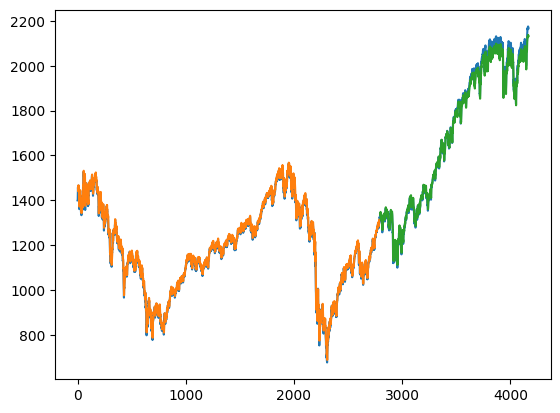

In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

**References:**

**[1] Advanced Forecasting with Python: With State-of-the-Art-Models Including LSTMs, Facebook’s Prophet, and Amazon’s DeepAR, Joos Korstanje, July 2021.**

**[2]. Deep Learning: Recurrent Neural Networks with Python, AI Sciences, 2021.**

**[3]. Deep Learning with Applications Using Python : Chatbots and Face, Object, and Speech Recognition With TensorFlow and Keras, Navin Kumar Manaswi, 2018.**

**[4]. Machine Vision, GANs, and Deep Reinforcement Learning, Jon Krohn, 2020.**

**[5]. Generating a New Reality: From Autoencoders and Adversarial Networks to Deepfakes, Micheal Lanham, 2021.**

**[6].Hands-On Mathematics for Deep Learning, Jay Dawani, 2020**


#Question 3
##Section A: Two Examples of A* Algorithm With Python Implementation

### A Breif Introduction To A* Search Algorithm:

The A* (A-star) algorithm is a popular and efficient pathfinding and graph traversal algorithm used to find the shortest path from a start node to a goal node in a weighted graph. A* maintains a priority queue of nodes to explore, where each node is scored based on the sum of the cost to reach that node (g(n)) and the estimated cost from that node to the goal (h(n)), known as the heuristic function. By prioritizing nodes with the lowest combined cost, A* efficiently finds the best path to the goal. It guarantees finding the shortest path when the heuristic used is accurate and never overestimates the actual cost.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

#Source: https://www.gatevidyalay.com/tag/a-star-search-algorithm-example/

Mounted at /content/drive


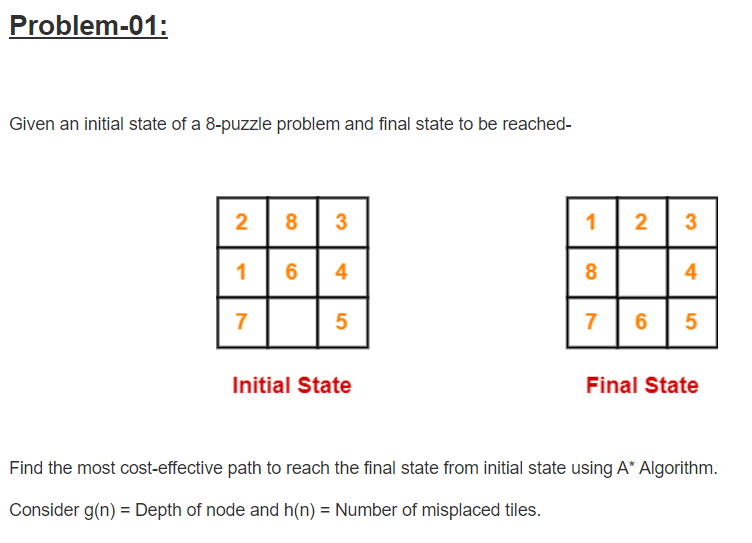

In [ ]:
from IPython.display import Image
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q3/part A/A-1.png")

#Source: https://www.gatevidyalay.com/tag/a-star-search-algorithm-example/

###Solution:

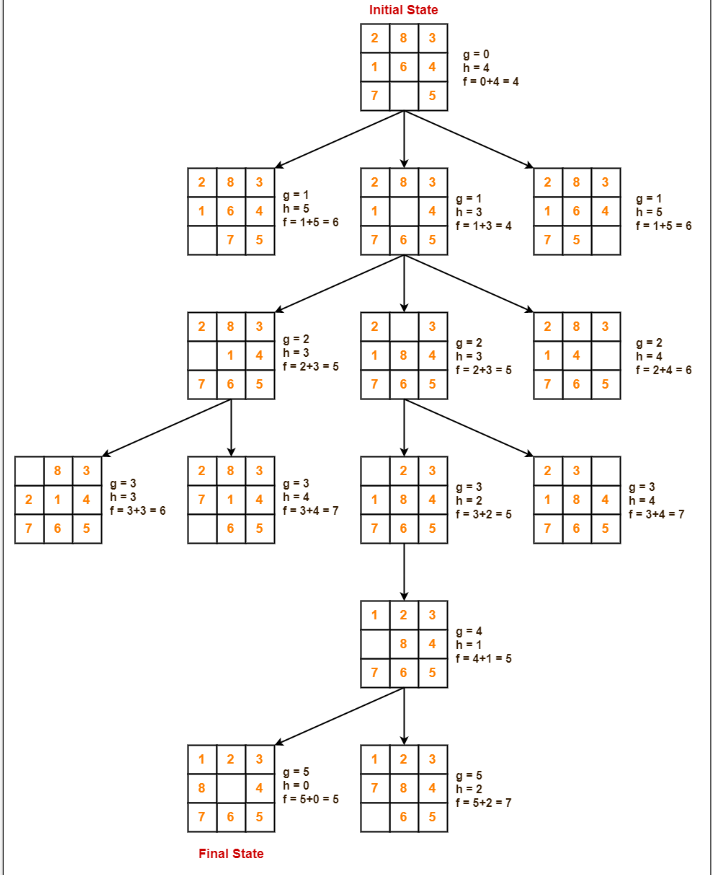

In [ ]:
from IPython.display import Image
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q3/part A/A-2.png")

#Source: https://www.gatevidyalay.com/tag/a-star-search-algorithm-example/

###Python Implementation:

for implementing the sort process, we build a class. each line is explained by a comment in this class as it is not possible to explain each method in different blocks do to class limits:

In [ ]:
import copy  # Import the copy module for deep copying the board
import heapq  # Import the heapq module for priority queue (min-heap) operations

class BoardGame:
    def __init__(self):
        self.board = [[2, 8, 3],  # Initial board configuration
                      [1, 6, 4],
                      [7, 0, 5]]

        self.final_board = [[1, 2, 3],  # Goal board configuration
                            [8, 0, 4],
                            [7, 6, 5]]

    def find_the_best_path(self):
        start = (self.board, [2, 1], 0, [])  # Initialize the start state (board, index_of_hole, G_value, path)
        heap = []  # Create an empty priority queue
        heapq.heappush(heap, (self.calculate_H(self.board), start))  # Push the initial state onto the heap with its heuristic value
        visited = set()  # Create an empty set to track visited states

        while heap:  # Loop while there are states in the heap
            _, (current_board, index_of_hole, G_value, path) = heapq.heappop(heap)  # Pop the state with the lowest priority (cost + heuristic)

            if self.is_goal(current_board):  # Check if the current board is the goal
                return path + [current_board]  # Return the path to the goal, including the final state

            visited.add(self.board_to_tuple(current_board))  # Mark the current board as visited

            for target in self.possible_moves(index_of_hole):  # Iterate over possible moves from the current hole position
                new_board = self.flip_tiles(target, index_of_hole, current_board)  # Generate a new board configuration by moving the hole
                if self.board_to_tuple(new_board) in visited:  # Skip if the new board configuration has already been visited
                    continue
                new_G_value = G_value + 1  # Increment the cost by 1
                new_H_value = self.calculate_H(new_board)  # Calculate the heuristic value of the new board
                heapq.heappush(heap, (new_G_value + new_H_value, (new_board, target, new_G_value, path + [current_board])))  # Push the new state onto the heap with its priority

        return None  # Return None if no solution is found

    def possible_moves(self, index_of_hole):  # Function to generate possible moves from the current hole position
        possible_next_moves = []  # List to store possible moves
        x, y = index_of_hole  # Current position of the hole
        if y + 1 < 3:  # Move right if within bounds
            possible_next_moves.append([x, y + 1])
        if y - 1 > -1:  # Move left if within bounds
            possible_next_moves.append([x, y - 1])
        if x + 1 < 3:  # Move down if within bounds
            possible_next_moves.append([x + 1, y])
        if x - 1 > -1:  # Move up if within bounds
            possible_next_moves.append([x - 1, y])
        return possible_next_moves  # Return the list of possible moves

    def flip_tiles(self, target, index_of_hole, input_board):  # Function to swap the hole with the target tile
        the_board = copy.deepcopy(input_board)  # Create a deep copy of the current board
        target_value = the_board[target[0]][target[1]]  # Get the value of the target tile
        the_board[target[0]][target[1]] = 0  # Set the target position to the hole (0)
        the_board[index_of_hole[0]][index_of_hole[1]] = target_value  # Move the target tile to the hole's position
        return the_board  # Return the new board configuration

    def calculate_H(self, current_board):  # Function to calculate the heuristic value (number of misplaced tiles)
        h = 0  # Initialize the heuristic value
        for i in range(len(self.final_board)):  # Iterate over the rows
            for j in range(len(self.final_board[0])):  # Iterate over the columns
                if current_board[i][j] != self.final_board[i][j] and current_board[i][j] != 0:  # Check if the tile is misplaced and not the hole
                    h += 1  # Increment the heuristic value for each misplaced tile
        return h  # Return the heuristic value

    def is_goal(self, board):  # Function to check if the board is the goal configuration
        return board == self.final_board  # Return True if the current board matches the goal configuration

    def board_to_tuple(self, board):  # Function to convert the board to a tuple (for use in sets)
        return tuple(tuple(row) for row in board)  # Return the board as a tuple of tuples


here we run our game to se what it does.

In [ ]:
the_board = BoardGame()
path = the_board.find_the_best_path()

if path:
    print("Path to solution:")
    for step in path:
        for row in step:
            print(row)
        print()
else:
    print("No solution found")

Path to solution:
[2, 8, 3]
[1, 6, 4]
[7, 0, 5]

[2, 8, 3]
[1, 0, 4]
[7, 6, 5]

[2, 0, 3]
[1, 8, 4]
[7, 6, 5]

[0, 2, 3]
[1, 8, 4]
[7, 6, 5]

[1, 2, 3]
[0, 8, 4]
[7, 6, 5]

[1, 2, 3]
[8, 0, 4]
[7, 6, 5]



as you can see it found the optimum solution, as we found in the example.

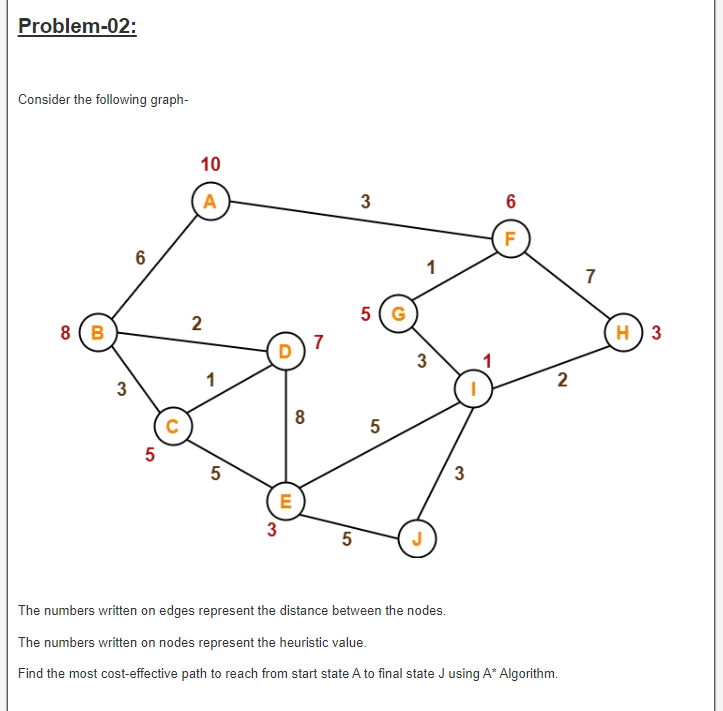

In [ ]:
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q3/part A/A-3.png")

#Source: https://www.gatevidyalay.com/tag/a-star-search-algorithm-example/

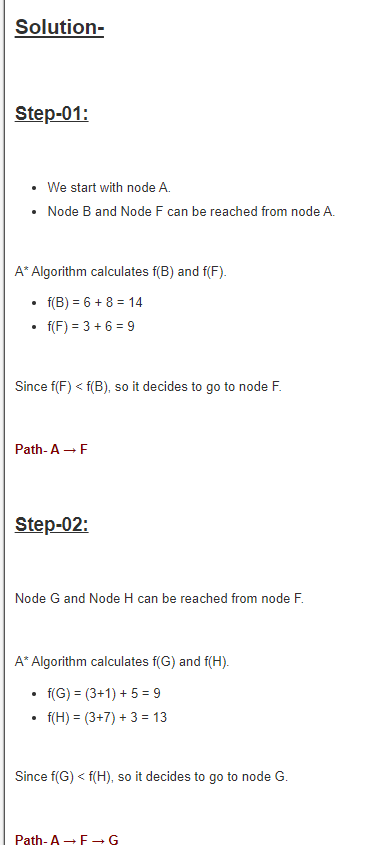

In [ ]:
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q3/part A/A-4.png")

#Source: https://www.gatevidyalay.com/tag/a-star-search-algorithm-example/

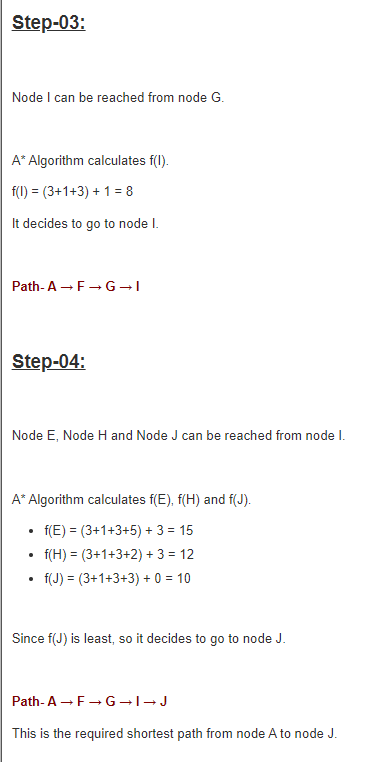

In [ ]:
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q3/part A/A-5.png")

#Source: https://www.gatevidyalay.com/tag/a-star-search-algorithm-example/

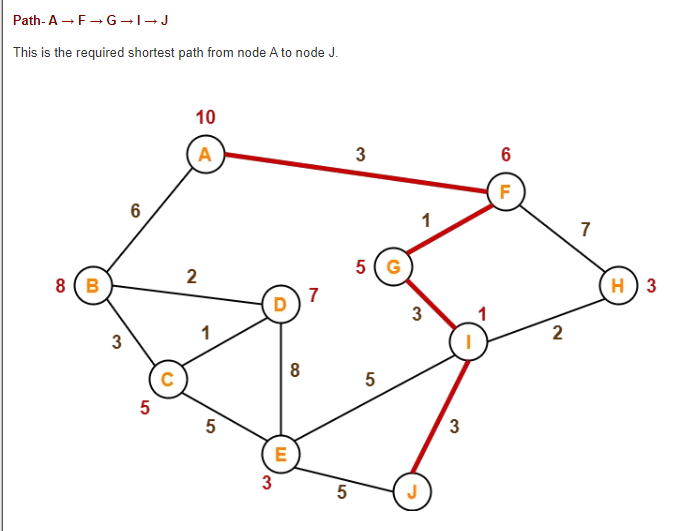

In [ ]:
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q3/part A/A-6.png")

#Source: https://www.gatevidyalay.com/tag/a-star-search-algorithm-example/

### Python Implementation:
We make a function to do the A* search on a given graph with heuristics. each line is explained by a comment:

In [ ]:
import heapq

def a_star_search(graph, heuristics, start, goal):
    pq = [(heuristics[start], start)]  # Initialize priority queue with heuristic value and starting node
    g_costs = {start: 0}  # Cost to reach start node is 0
    came_from = {start: None}  # Record the path where each node came from

    while pq:
        _, current = heapq.heappop(pq)  # Pop node with the lowest cost from priority queue

        if current == goal:
            path = []
            while current:
                path.append(current)  # Build the path backward from goal to start
                current = came_from[current]  # Move to parent node
            path.reverse()  # Reverse to get path from start to goal
            return path  # Return the reconstructed path

        for neighbor, cost in graph[current].items():
            new_cost = g_costs[current] + cost  # Calculate new cost to reach neighbor

            if neighbor not in g_costs or new_cost < g_costs[neighbor]:
                g_costs[neighbor] = new_cost  # Update cost to reach neighbor
                priority = new_cost + heuristics[neighbor]  # Calculate priority based on heuristic
                heapq.heappush(pq, (priority, neighbor))  # Push neighbor into priority queue
                came_from[neighbor] = current  # Record the path by setting the parent node

    return None  # Return None if no path is found

we use our function to solve the graph of our question:

In [ ]:
graph = {
    'A': {'B': 6, 'F': 3},
    'B': {'A': 6, 'C': 3, 'D': 2},
    'C': {'B': 3, 'D': 1, 'E': 5},
    'D': {'B': 2, 'E': 8, 'C': 1},
    'E': {'C': 5, 'D': 8, 'I': 5, 'J': 5},
    'F': {'A': 3, 'G': 1, 'H': 7},
    'G': {'F': 1, 'I': 3},
    'H': {'F': 7, 'I': 2},
    'I': {'E': 5, 'G': 3, 'H': 2, 'J': 3},
    'J': {'E': 5, 'I': 3}
}

heuristics = {
    'A': 10,
    'B': 8,
    'C': 5,
    'D': 7,
    'E': 3,
    'F': 6,
    'G': 5,
    'H': 3,
    'I': 1,
    'J': 0
}

path = a_star_search(graph, heuristics, 'A', 'J')
print("Path from A to J:", path)

Path from A to J: ['A', 'F', 'G', 'I', 'J']


as you can see the answer also matches this time.

References:

(1) a-start search algorithm example: https://www.gatevidyalay.com/tag/a-star-search-algorithm-example/

##Section B: Two Examples Of The Min-Max Search:

### Explanation of Minimax Search

The minimax algorithm is a decision-making algorithm used in two-player games like chess, tic-tac-toe, etc. It provides an optimal move for the player by assuming that the opponent also plays optimally.

1. **Minimax Process:**
   - **Maximizing Player (MAX):** This player tries to maximize the score.
   - **Minimizing Player (MIN):** This player tries to minimize the score.
   - The game tree is traversed depth-first, and values are propagated upwards from the leaves to the root.
   - At each level of the tree, the algorithm alternates between the maximizing and minimizing player.
   
2. **Evaluation Function:** At the leaves of the tree, an evaluation function provides a score for the game state from the perspective of the maximizing player.

3. **Decision Making:**
   - The root node represents the current state.
   - The optimal move for the maximizing player is the move that leads to the maximum value.
   - The minimizing player chooses the move that leads to the minimum value.



### Problem 1

In [ ]:
from IPython.display import Image
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


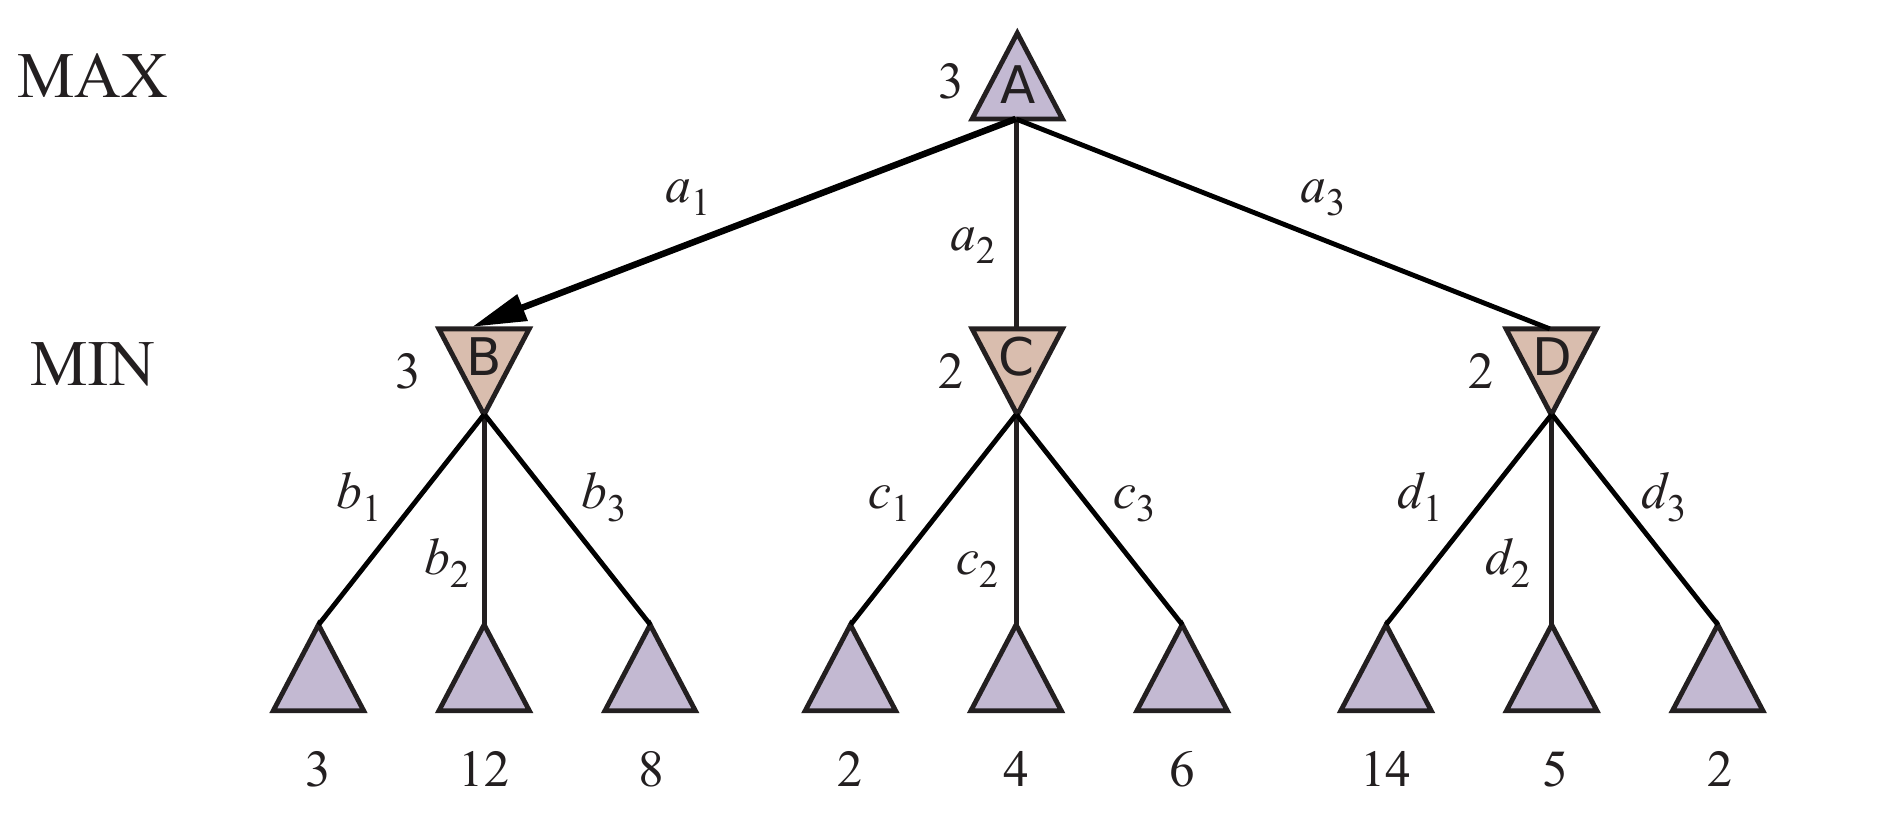

In [ ]:
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q3/part-B/B-1.png", width = 750, height = 450)

# Source: Stuart Russell and Peter Norvig - Artificial Intelligence_ A Modern Approach-Pearson (2020)

### Solution

This represents a game tree where:
- The root node (A) is a decision point for the MAX player.
- The second level nodes (B, C, D) are decision points for the MIN player.
- The leaf nodes represent the final outcomes of the game, with numerical       
  values indicating the score from the perspective of the MAX player.

### Analysis of the Tree

1. Start from the leaves and propagate the values upwards:
   - **B Node (MIN):**
     - \( b1 = 3 \)
     - \( b2 = 12 \)
     - \( b3 = 8 \)
     - MIN chooses the smallest value: ( MIN(3, 12, 8) = 3 )
   - **C Node (MIN):**
     - \( c1 = 2 \)
     - \( c2 = 4 \)
     - \( c3 = 6 \)
     - MIN chooses the smallest value: ( MIN(2, 4, 6) = 2 )
   - **D Node (MIN):**
     - \( d1 = 14 \)
     - \( d2 = 5 \)
     - \( d3 = 2 \)
     - MIN chooses the smallest value: ( MIN(14, 5, 2) = 2 )
2. Now the values for the nodes B, C, and D are propagated to the root (A):
   - \( a1 = 3 \)
   - \( a2 = 2 \)
   - \( a3 = 2 \)
   - MAX chooses the largest value: ( MAX(3, 2, 2) = 3 )

Therefore, the optimal move for the MAX player results in a score of 3.


### Python Implementation

Here is the code that implements the minimax algorithm and applies it to the given tree. Each line is explained by a comment:

In [ ]:
# Define the Node class to represent each node in the tree
class Node:
    def __init__(self, value=None, children=None):
        self.value = value  # Initialize the value of the node (used for leaf nodes)
        self.children = children if children is not None else []  # Initialize the children of the node

# Define the minimax function to perform the minimax search
def minimax(node, depth, is_maximizing_player):
    # Base case: if the node is a leaf or depth is 0, return the node's value
    if depth == 0 or not node.children:
        return node.value

    # If the current node is a maximizing player
    if is_maximizing_player:
        max_eval = float('-inf')  # Initialize max evaluation to negative infinity
        # Recursively call minimax for each child and update max_eval
        for child in node.children:
            eval = minimax(child, depth - 1, False)  # Switch to minimizing player
            max_eval = max(max_eval, eval)
        node.value = max_eval  # Update the node's value with max evaluation
        return max_eval  # Return max evaluation
    else:
        # If the current node is a minimizing player
        min_eval = float('inf')  # Initialize min evaluation to positive infinity
        # Recursively call minimax for each child and update min_eval
        for child in node.children:
            eval = minimax(child, depth - 1, True)  # Switch to maximizing player
            min_eval = min(min_eval, eval)
        node.value = min_eval  # Update the node's value with min evaluation
        return min_eval  # Return min evaluation

# Define the leaf nodes for the tree structure from our example
leaf_b = [Node(3), Node(12), Node(8)]
leaf_c = [Node(2), Node(4), Node(6)]
leaf_d = [Node(14), Node(5), Node(2)]

# Define the intermediate nodes B, C, and D with their respective children
node_b = Node(children=leaf_b)
node_c = Node(children=leaf_c)
node_d = Node(children=leaf_d)

# Define the root node A with its children B, C, and D
root = Node(children=[node_b, node_c, node_d])

# Perform minimax search on the tree starting from the root node
optimal_value = minimax(root, depth=2, is_maximizing_player=True)

# Print the optimal value for the maximizing player
print(f"Optimal value for the maximizing player is: {optimal_value}")


Optimal value for the maximizing player is: 3


### Problem 2

Here is another graph that we will do the  minmax search on it:

In [ ]:
Image(url = "https://static.javatpoint.com/tutorial/ai/images/mini-max-algorithm-in-ai-step1.png")

### Analysis of the Tree

1. Start from the leaves and propagate the values upwards:
   - **D Node (MAX):**
     - \( d1 = -1 \)
     - \( d2 = 4 \)
     
     - MAX chooses the biggest value: ( MAX(-1,4) = 4 )
   - **E Node (MAX):**
     - \( e1 = 2 \)
     - \( e2 = 6 \)
     
     - MAX chooses the biggest value: ( MAX(2,6) = 6 )
   - **F Node (MAX):**
     - \( f1 = -3 \)
     - \( f2 = -5 \)
     
    - MAX chooses the biggest value: ( MAX(-3,-5) = -3 )
   - **G Node (MAX):**
     - \( g1 = 0 \)
     - \( g2 = 7 \)
     
    - MAX chooses the biggest value: ( MAX(0,7) = 7 )

2. Now the values for the nodes B, C must be obtained. this level is  min turn:

   - **B Node (MIN):**
     - \( b1 = 4 \)
     - \( b2 = 6 \)
     
    - MIN chooses the smallest value: ( MIN(4,6) = 4 )
   - **C Node (MIN):**
     - \( c1 = -3 \)
     - \( c2 = 7 \)
     
    - MIN chooses the smallest value: ( MIN(-3,7) = -3 )

3. Lastley we reach the node, where we choose 4 between -3 and 4, so the answer will be 4.

###Python Implementation

In [ ]:
# Define the leaf nodes for the tree structure from the example
leaf_d = [Node(-1), Node(4)]
leaf_e = [Node(2), Node(6)]
leaf_f = [Node(-3), Node(-5)]
leaf_g = [Node(0), Node(7)]

# Define the intermediate nodes D, E, F, and G with their respective children
node_d = Node(children=leaf_d)
node_e = Node(children=leaf_e)
node_f = Node(children=leaf_f)
node_g = Node(children=leaf_g)

# Define the second level nodes B and C with their respective children
node_b = Node(children=[node_d, node_e])
node_c = Node(children=[node_f, node_g])

# Define the root node A with its children B and C
root = Node(children=[node_b, node_c])

# Perform minimax search on the tree starting from the root node (A)
optimal_value = minimax(root,3, is_maximizing_player=True)

# Print the optimal value for the maximizing player
print(f"Optimal value for the maximizing player is: {optimal_value}")

Optimal value for the maximizing player is: 4


References:

(1) Stuart Russell and Peter Norvig - Artificial Intelligence_ A Modern Approach-Pearson (2020)

(2) minimax algoritm in artificial inteligence: https://www.javatpoint.com/mini-max-algorithm-in-ai

##Section C: Explaining About BFS, DFS and UCS With An Example

###BFS:
Breadth-First Search (BFS) is an algorithm used to traverse or search through a graph or tree. It starts at a given node (called the root) and explores all its neighboring nodes at the present depth level before moving on to nodes at the next depth level. BFS uses a queue to keep track of the nodes to be explored next, ensuring it visits nodes level by level.

Now let's consdier the following graph, which we will apply BFS on it from root node A.

```
     A
    / \
   B   C
  / \   \
 D   E   F
```

Here we apply BFS from node A:

| Step | Action                     | Queue          | Visited                | Traversal Order          |
|------|----------------------------|----------------|------------------------|--------------------------|
| 1    | Initialize                 | `[A]`          | `[]`                   | `[]`                     |
| 2    | Visit Node `A`             | `[]`           | `[A]`                  | `[A]`                    |
| 3    | Enqueue neighbors of `A`   | `[B, C]`       | `[A]`                  | `[A]`                    |
| 4    | Visit Node `B`             | `[C]`          | `[A, B]`               | `[A, B]`                 |
| 5    | Enqueue neighbors of `B`   | `[C, D, E]`    | `[A, B]`               | `[A, B]`                 |
| 6    | Visit Node `C`             | `[D, E]`       | `[A, B, C]`            | `[A, B, C]`              |
| 7    | Enqueue neighbors of `C`   | `[D, E, F]`    | `[A, B, C]`            | `[A, B, C]`              |
| 8    | Visit Node `D`             | `[E, F]`       | `[A, B, C, D]`         | `[A, B, C, D]`           |
| 9    | Enqueue neighbors of `D`   | `[E, F]`       | `[A, B, C, D]`         | `[A, B, C, D]`           |
| 10   | Visit Node `E`             | `[F]`          | `[A, B, C, D, E]`      | `[A, B, C, D, E]`        |
| 11   | Enqueue neighbors of `E`   | `[F]`          | `[A, B, C, D, E]`      | `[A, B, C, D, E]`        |
| 12   | Visit Node `F`             | `[]`           | `[A, B, C, D, E, F]`   | `[A, B, C, D, E, F]`     |
| 13   | Enqueue neighbors of `F`   | `[]`           | `[A, B, C, D, E, F]`   | `[A, B, C, D, E, F]`     |

So the BFS traversal order starting from node `A` is:

```
[A, B, C, D, E, F]
```

### Python Implementation

In [ ]:
from collections import deque

# Define the graph using an adjacency list
graph = {
    'A': ['B', 'C'],
    'B': ['A', 'D', 'E'],
    'C': ['A', 'F'],
    'D': ['B'],
    'E': ['B'],
    'F': ['C']
}

# BFS function
def bfs(start_node):
    visited = []         # List to keep track of visited nodes
    queue = deque([start_node])  # Initialize a queue with the start node

    while queue:
        node = queue.popleft()  # Dequeue a node from the queue

        if node not in visited:
            visited.append(node)  # Mark the node as visited
            queue.extend([neighbor for neighbor in graph[node] if neighbor not in visited])  # Enqueue all adjacent unvisited nodes

    return visited

# Perform BFS starting from node 'A'
bfs_traversal_order = bfs('A')
print(f"BFS Traversal Order: {bfs_traversal_order}")


BFS Traversal Order: ['A', 'B', 'C', 'D', 'E', 'F']


### DFS

Depth-First Search (DFS) is another searching algorithm. The algorithm starts at the root node and explores as far as possible along each branch before backtracking. DFS uses a stack to keep track of the nodes to be visited next.

### Graph

Here is the graph structure we want to perform DFS on:

```
     A
    / \
   B   C
  / \   \
 D   E   F
```

### Table of DFS Algorithm Steps

| Step | Action                     | Stack           | Visited                | Traversal Order          |
|------|----------------------------|-----------------|------------------------|--------------------------|
| 1    | Initialize                 | `[A]`           | `[]`                   | `[]`                     |
| 2    | Visit Node `A`             | `[B, C]`        | `[A]`                  | `[A]`                    |
| 3    | Visit Node `B`             | `[D, E, C]`     | `[A, B]`               | `[A, B]`                 |
| 4    | Visit Node `D`             | `[E, C]`        | `[A, B, D]`            | `[A, B, D]`              |
| 5    | Backtrack to Node `B`      | `[E, C]`        | `[A, B, D]`            | `[A, B, D]`              |
| 6    | Visit Node `E`             | `[C]`           | `[A, B, D, E]`         | `[A, B, D, E]`           |
| 7    | Backtrack to Node `B`      | `[C]`           | `[A, B, D, E]`         | `[A, B, D, E]`           |
| 8    | Backtrack to Node `A`      | `[C]`           | `[A, B, D, E]`         | `[A, B, D, E]`           |
| 9    | Visit Node `C`             | `[F]`           | `[A, B, D, E, C]`      | `[A, B, D, E, C]`        |
| 10   | Visit Node `F`             | `[]`            | `[A, B, D, E, C, F]`   | `[A, B, D, E, C, F]`     |   |

Therefore the DFS traversal order starting from node `A` is:

```
[A, B, D, E, C, F]
```

### Python Implementation

In [ ]:
# Define the graph using an adjacency list (symmetric)
graph = {
    'A': ['B', 'C'],
    'B': ['A', 'D', 'E'],
    'C': ['A', 'F'],
    'D': ['B'],
    'E': ['B'],
    'F': ['C']
}

# DFS function
def dfs(node, visited):
    if node not in visited:
        visited.append(node)  # Mark the node as visited
        for neighbor in graph[node]:
            dfs(neighbor, visited)  # Visit all the neighbors
    return visited

# Perform DFS starting from node 'A'
dfs_traversal_order = dfs('A', [])
print(f"DFS Traversal Order: {dfs_traversal_order}")

DFS Traversal Order: ['A', 'B', 'D', 'E', 'C', 'F']


###UCS

Long story short, UCS is the A* algorithm with all heuristics being equall to 0 (in another words f(n) = g(n) and in each step we choose the node with smallest value of f(n) and expand it). Now we use the example in section A of this question with no heuristics:

In [ ]:
from google.colab import drive
from IPython.display import Image

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


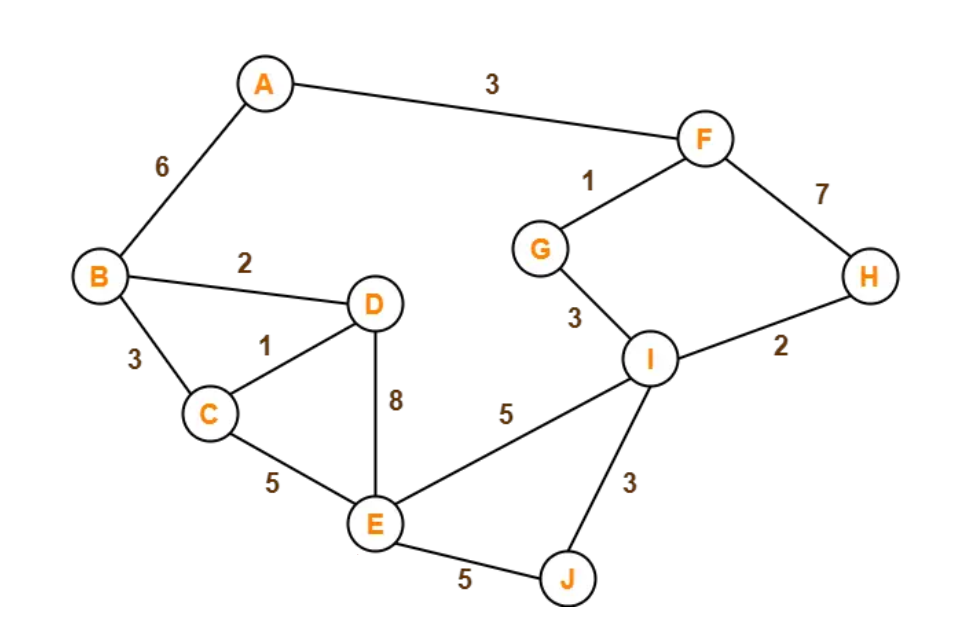

In [ ]:
Image(filename = "/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q3/part C/C-1.png",width = 750, height = 500)

So steps for this graph will be:
1. node A has two neighbors, B and F which f(B) = 6 and f(F) = 3 so F is chosen.

2. node F has two neighbors, G and H which f(G) = 3 + 1 and f(H) = 3 + 7 so G is chosen.

3. node G has only one unseen neighbor, I so it will be chosen.

4. node I has three unseen neighbors, J and H and E which f(H) = 3 + 1 + 3 + 2 and f(J) = 3 + 1 + 3 + 3 and f(E) = 3 + 1 + 3 + 5 so H is chosen.

5. H has no unseen neighbors, so this branch will be terminated. therefore the next best node will be chosen, which is J, which is our answer.

so the shortest path will be:

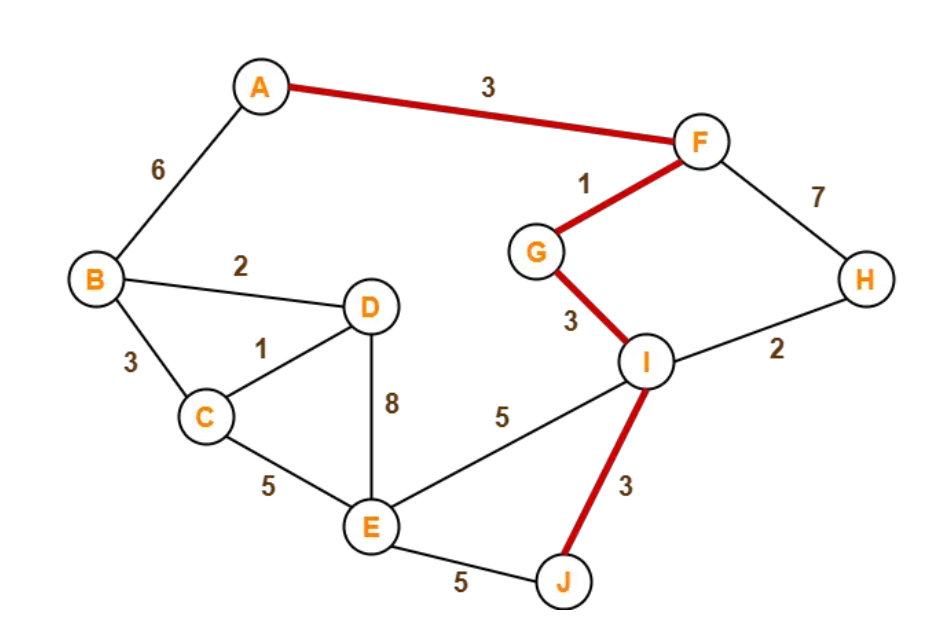

In [ ]:
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q3/part C/c-2.png",width = 750, height = 500)

###Python Implementation

We use the same function of the A* search, but we set the heuristics equal to 0:

In [ ]:
import heapq

def a_star_search(graph, heuristics, start, goal):
    pq = [(heuristics[start], start)]  # Initialize priority queue with heuristic value and starting node
    g_costs = {start: 0}  # Cost to reach start node is 0
    came_from = {start: None}  # Record the path where each node came from

    while pq:
        _, current = heapq.heappop(pq)  # Pop node with the lowest cost from priority queue

        if current == goal:
            path = []
            while current:
                path.append(current)  # Build the path backward from goal to start
                current = came_from[current]  # Move to parent node
            path.reverse()  # Reverse to get path from start to goal
            return path  # Return the reconstructed path

        for neighbor, cost in graph[current].items():
            new_cost = g_costs[current] + cost  # Calculate new cost to reach neighbor

            if neighbor not in g_costs or new_cost < g_costs[neighbor]:
                g_costs[neighbor] = new_cost  # Update cost to reach neighbor
                priority = new_cost + heuristics[neighbor]  # Calculate priority based on heuristic
                heapq.heappush(pq, (priority, neighbor))  # Push neighbor into priority queue
                came_from[neighbor] = current  # Record the path by setting the parent node

    return None  # Return None if no path is found

graph = {
    'A': {'B': 6, 'F': 3},
    'B': {'A': 6, 'C': 3, 'D': 2},
    'C': {'B': 3, 'D': 1, 'E': 5},
    'D': {'B': 2, 'E': 8, 'C': 1},
    'E': {'C': 5, 'D': 8, 'I': 5, 'J': 5},
    'F': {'A': 3, 'G': 1, 'H': 7},
    'G': {'F': 1, 'I': 3},
    'H': {'F': 7, 'I': 2},
    'I': {'E': 5, 'G': 3, 'H': 2, 'J': 3},
    'J': {'E': 5, 'I': 3}
}

heuristics = {
    'A': 0,
    'B': 0,
    'C': 0,
    'D': 0,
    'E': 0,
    'F': 0,
    'G': 0,
    'H': 0,
    'I': 0,
    'J': 0
}

path = a_star_search(graph, heuristics, 'A', 'J')
print("Path from A to J:", path)

Path from A to J: ['A', 'F', 'G', 'I', 'J']


References:

(1) UCS search algorithm: https://www.scaler.com/topics/uniform-cost-search/

(2) a-star-search-algorithm-example: https://www.gatevidyalay.com/tag/a-star-search-algorithm-example/

##Section D: Solving A CSP:

in this section we must color each territory with 4 colors such that no adjacant territories have the same color:

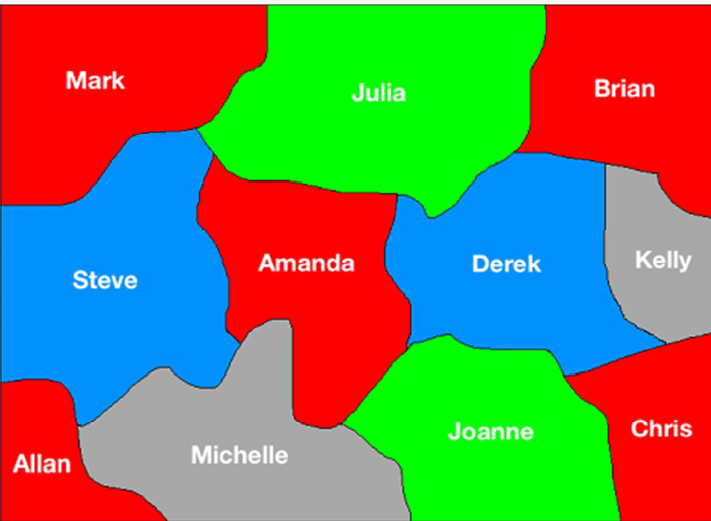

In [ ]:
Image(filename="/content/drive/MyDrive/AI-SUMMER-2024/ai-project-3/q3/part D/D-1.png")

First we must install and import the simpleai library for searching operation

In [ ]:
!pip install simpleai
from simpleai.search import CspProblem, backtrack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 909.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simpleai: filename=simpleai-0.8.3-py3-none-any.whl size=100985 sha256=7720546eabba4f6af4ba38e2204562c785cd16576805240313a50ac3288e1bbe
  Stored in directory: /root/.cache/pip/wheels/91/0c/38/421d7910e7bc59b97fc54f490808bdb1097607d83d1a592865
Successfully built simpleai


Here we write the python code to solve this CSP. Each line is explained by a comment.

In [ ]:
from simpleai.search import CspProblem, backtrack

# Define the constraint function that ensures two connected nodes have different colors
def constraint_function(names, values):
    return values[0] != values[1]

# Define the names (nodes) in the graph
names = ('Mark', 'Julia', 'Steve', 'Amanda', 'Brian',
         'Joanne', 'Derek', 'Allan', 'Michelle', 'Kelly', 'Chris')

# Create a dictionary where each node has a list of possible colors
name_color_map = dict((name, ['red', 'green', 'blue', 'gray']) for name in names)

# Define the constraints as pairs of nodes and the constraint function to apply to each pair
constraints = [
    (('Mark', 'Julia'), constraint_function),
    (('Mark', 'Steve'), constraint_function),
    (('Steve', 'Amanda'), constraint_function),
    (('Steve', 'Julia'), constraint_function),
    (('Steve', 'Allan'), constraint_function),
    (('Steve', 'Michelle'), constraint_function),
    (('Julia', 'Derek'), constraint_function),
    (('Julia', 'Amanda'), constraint_function),
    (('Julia', 'Brian'), constraint_function),
    (('Joanne', 'Amanda'), constraint_function),
    (('Joanne', 'Derek'), constraint_function),
    (('Joanne', 'Kelly'), constraint_function),
    (('Joanne', 'Michelle'), constraint_function),
    (('Joanne', 'Chris'), constraint_function),
    (('Amanda', 'Michelle'), constraint_function),
    (('Amanda', 'Derek'), constraint_function),
    (('Brian', 'Derek'), constraint_function),
    (('Brian', 'Kelly'), constraint_function),
    (('Derek', 'Kelly'), constraint_function),
    (('Derek', 'Chris'), constraint_function),
    (('Chris', 'Kelly'), constraint_function)
]

# Create the CSP problem instance with the nodes, domains, and constraints
problem = CspProblem(names, name_color_map, constraints)

# Solve the CSP problem using the backtrack algorithm
output = backtrack(problem)

# Print the solution, displaying the color assigned to each node
for name, color in output.items():
    print(f"{name} color is: {color}")


Mark color is: red
Julia color is: green
Steve color is: blue
Amanda color is: red
Brian color is: red
Joanne color is: green
Derek color is: blue
Allan color is: red
Michelle color is: gray
Kelly color is: gray
Chris color is: red
